# Analyza EMM pomoci foton-korelacni metody vcetne odhadu nejistot

## Odhad sigmy bodů histogramu

Nejprve se chystám odhadnout sigmu naměřených histogramů. Tzn. měření na picoharpu.

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# data import
#import pandas as pd
import numpy as np

#data_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_delim.txt", sep="\t").values
#voltages_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_voltages.txt", sep="\t").values

data_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")
data_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")
data_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_delim.txt", delimiter="\t")[:,:2]
voltages_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_voltages.txt", delimiter="\t")

fotkor_bezcond=np.concatenate( (data_bezcond_p1 ,data_bezcond_p2, data_bezcond_p3) ,axis=1)
voltages_bezcond=np.concatenate( (voltages_bezcond_p1 ,voltages_bezcond_p2, voltages_bezcond_p3) ,axis=0)




# pomocne promene
fotkor_shape = np.shape(fotkor_bezcond)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res


#---------- odecet pozadi
background_photocounts = 400 # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
bg_ph_sum = background_photocounts * t_measure  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio = fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin = bg_ph_sum/(fotkor_shape[0]-2 + last_bin_ratio)

fotkor_bezcond[:fotkor_shape[0]-2,:] = fotkor_bezcond[:fotkor_shape[0]-2,:] - bg_ph_per_bin 
fotkor_bezcond[fotkor_shape[0]-2,:] = fotkor_bezcond[fotkor_shape[0]-2,:] - bg_ph_per_bin * last_bin_ratio
# ------------------------------

Vyberu histogram s nejmenším MM

In [3]:
# odhad periody triggeru
T_trig = ( fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9] )* t_res + t_scale[fotkor_shape[0]-2]

T_trig_sigma = t_res
# frekvence buzeni pasti

drive_freq = 1/T_trig
drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
Omega = 2*np.pi * drive_freq
Omega_sigma = 2*np.pi * drive_freq_sigma
drive_freq

30032035.976450287

In [4]:
# funkce vracejici residua
def fit_resid(x, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return S - S_fit

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

In [5]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), -1.5]

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    x[:,i] = fit.x
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    

In [6]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

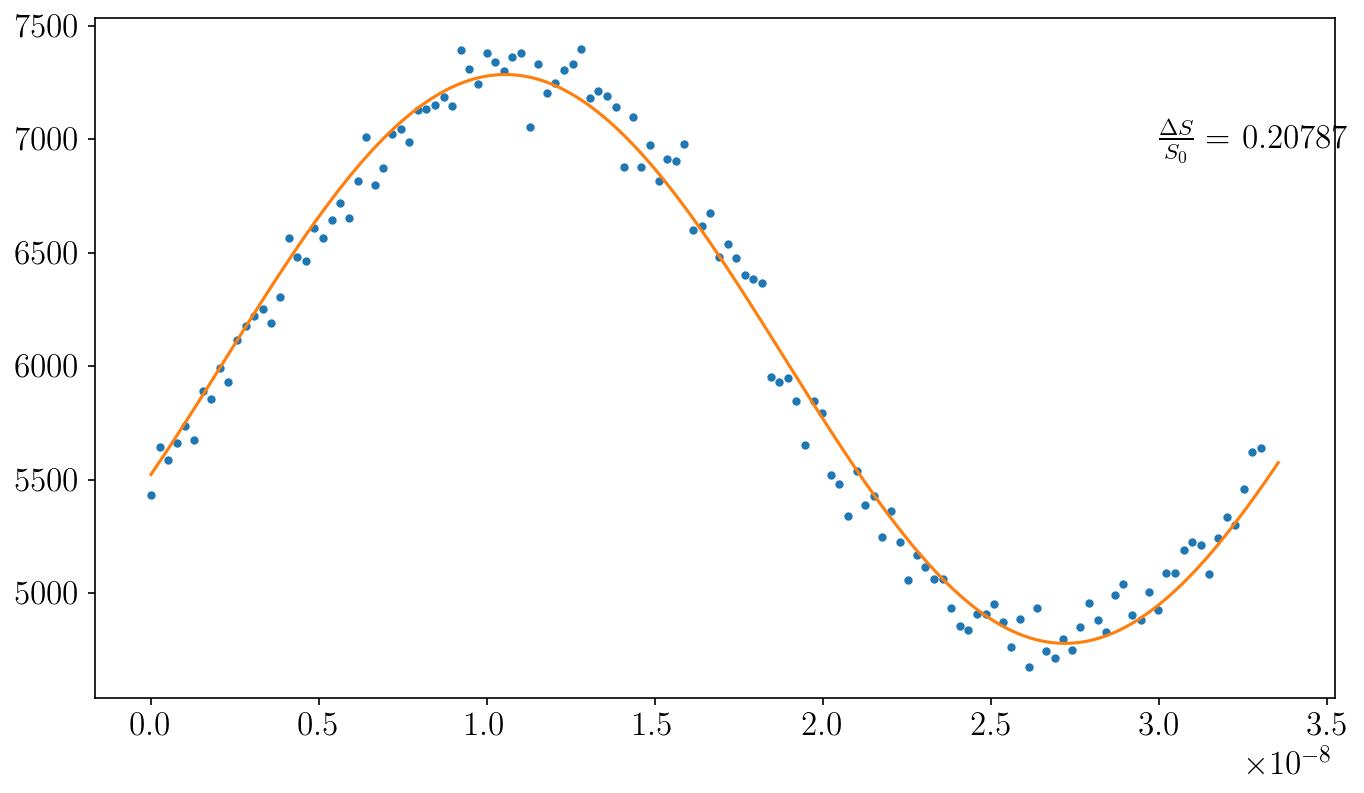

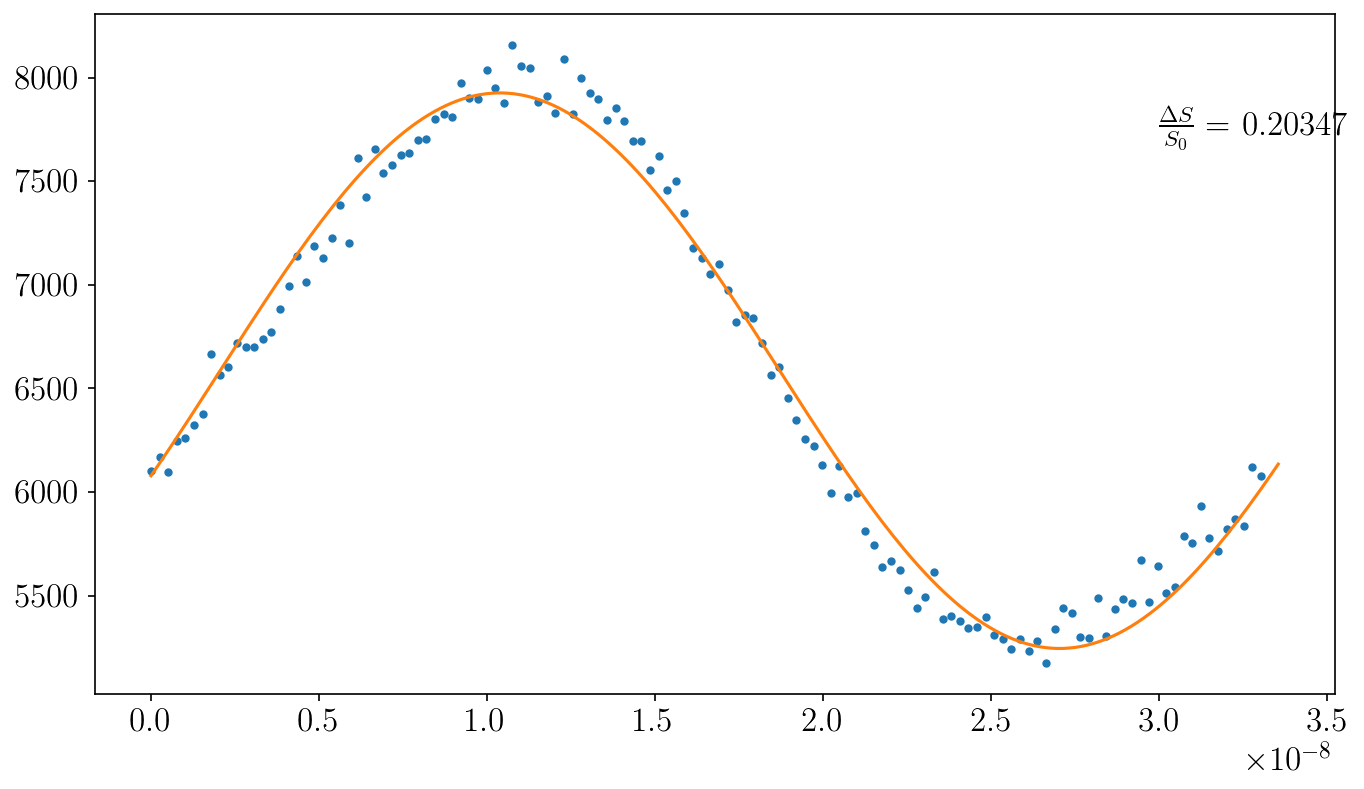

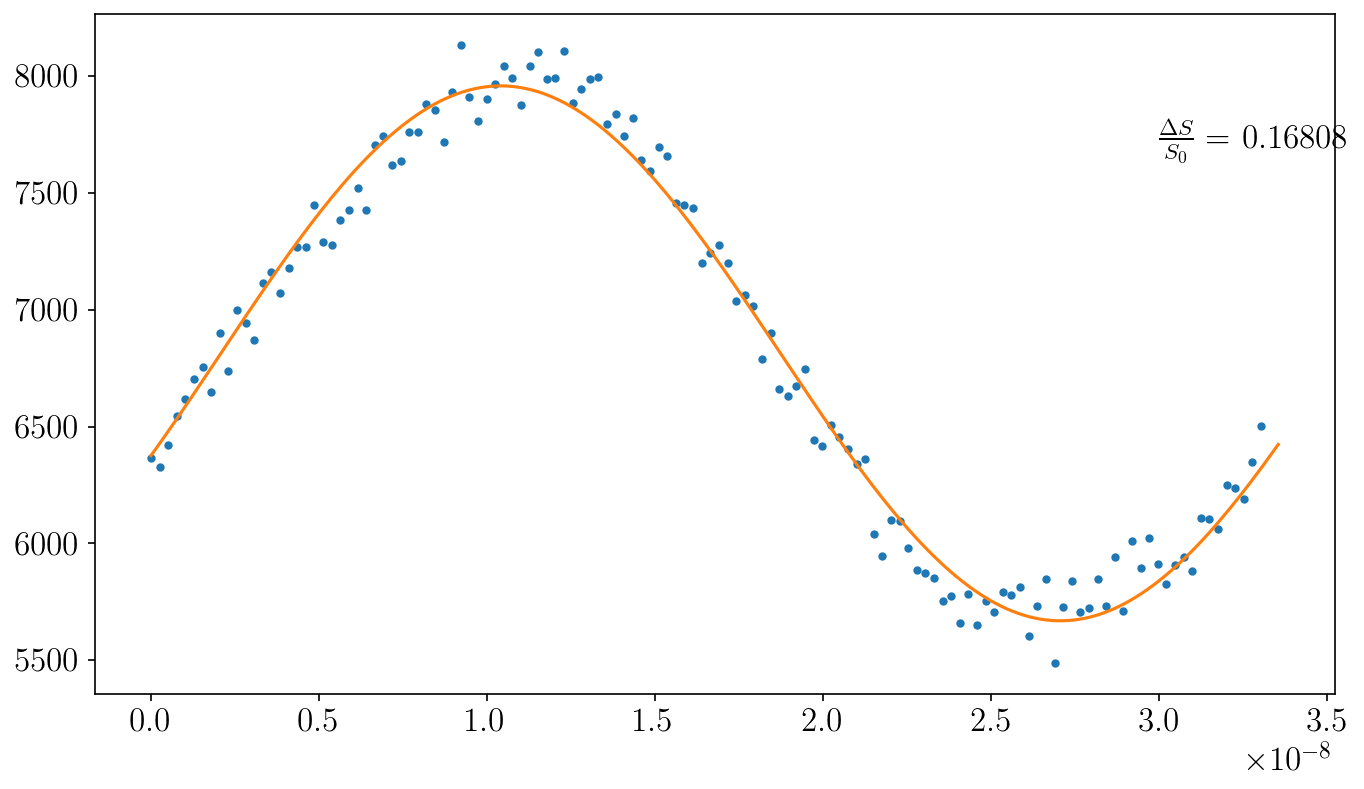

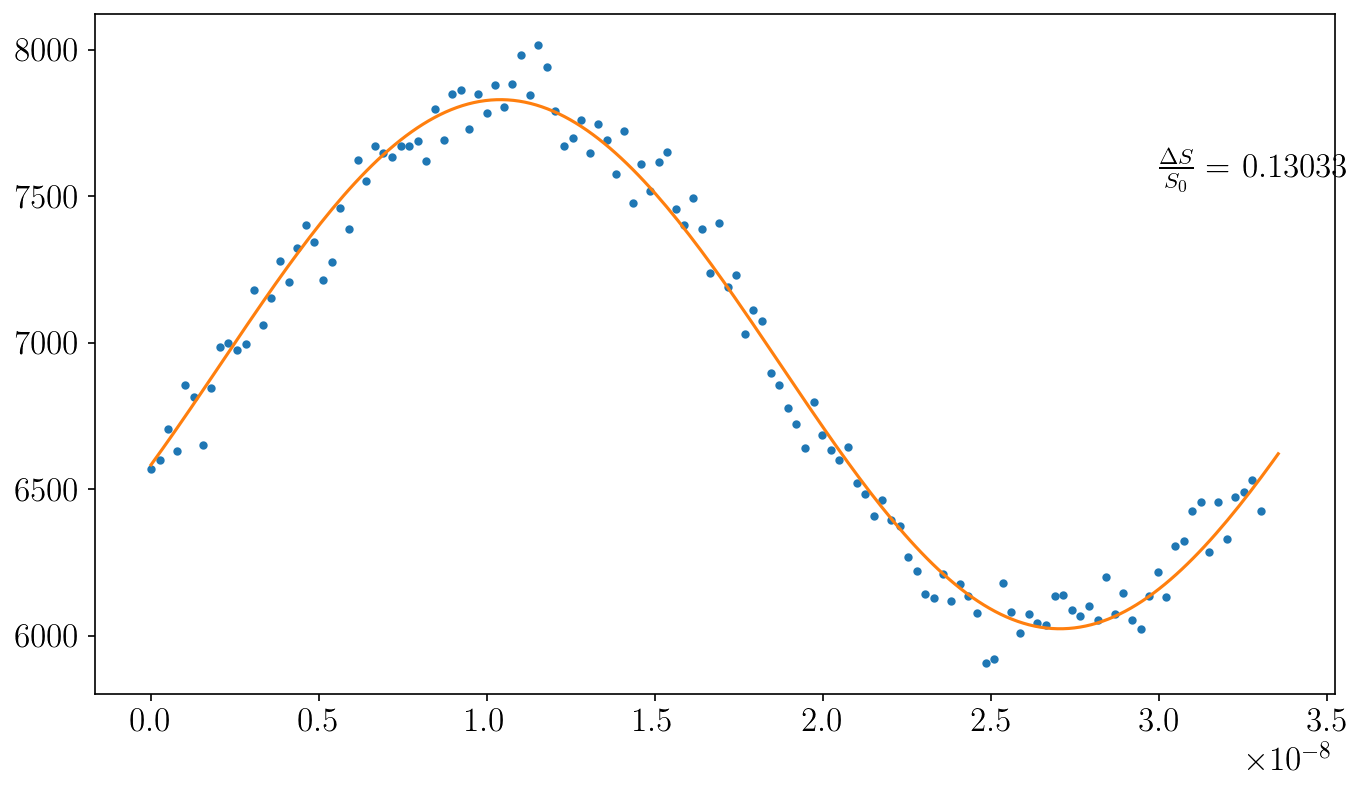

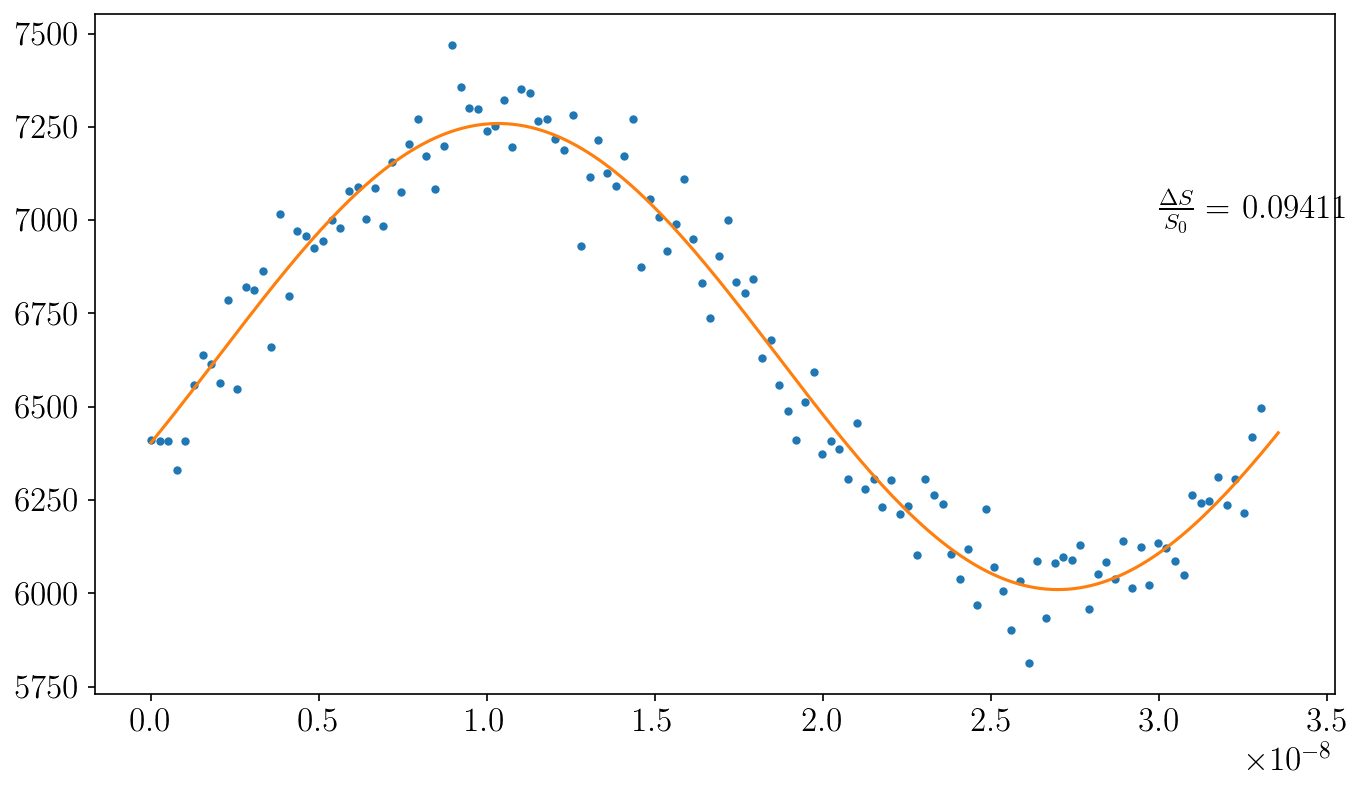

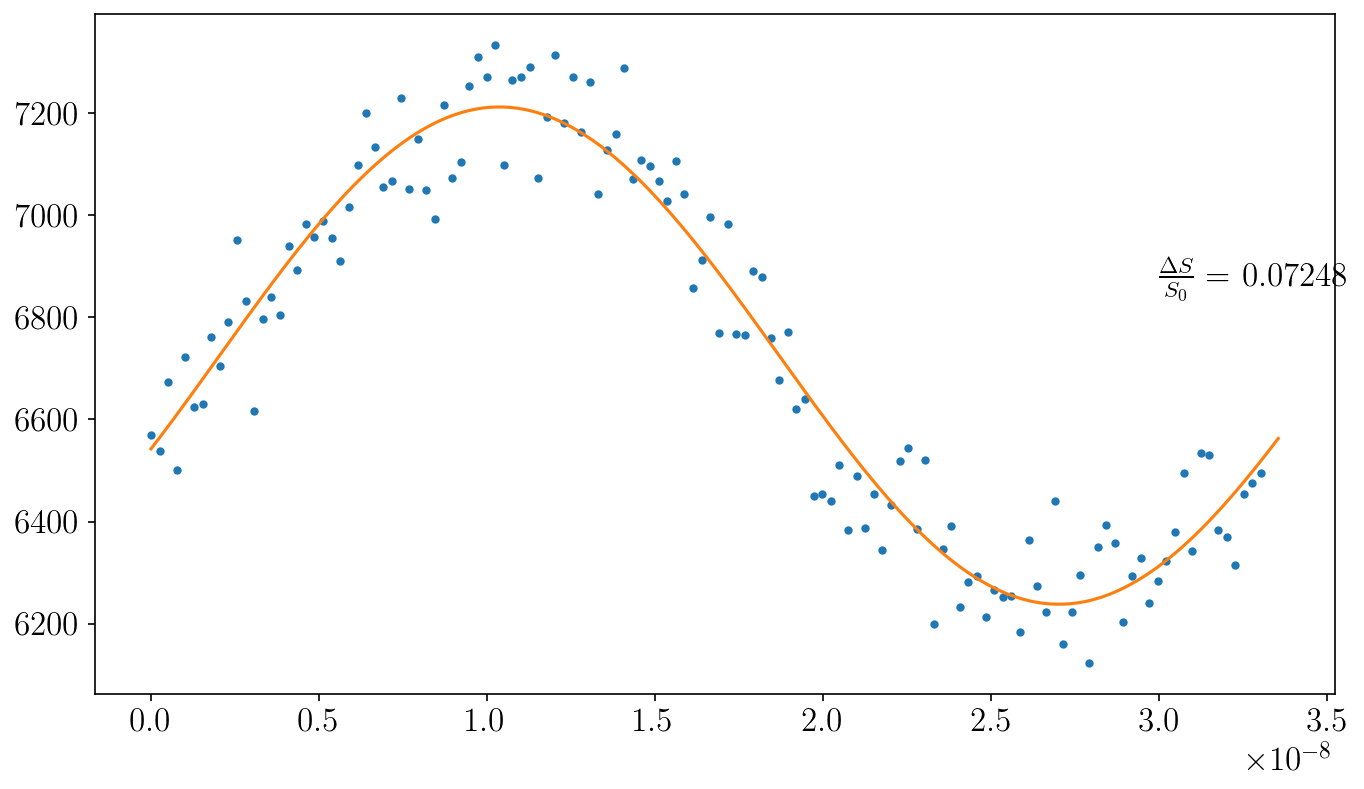

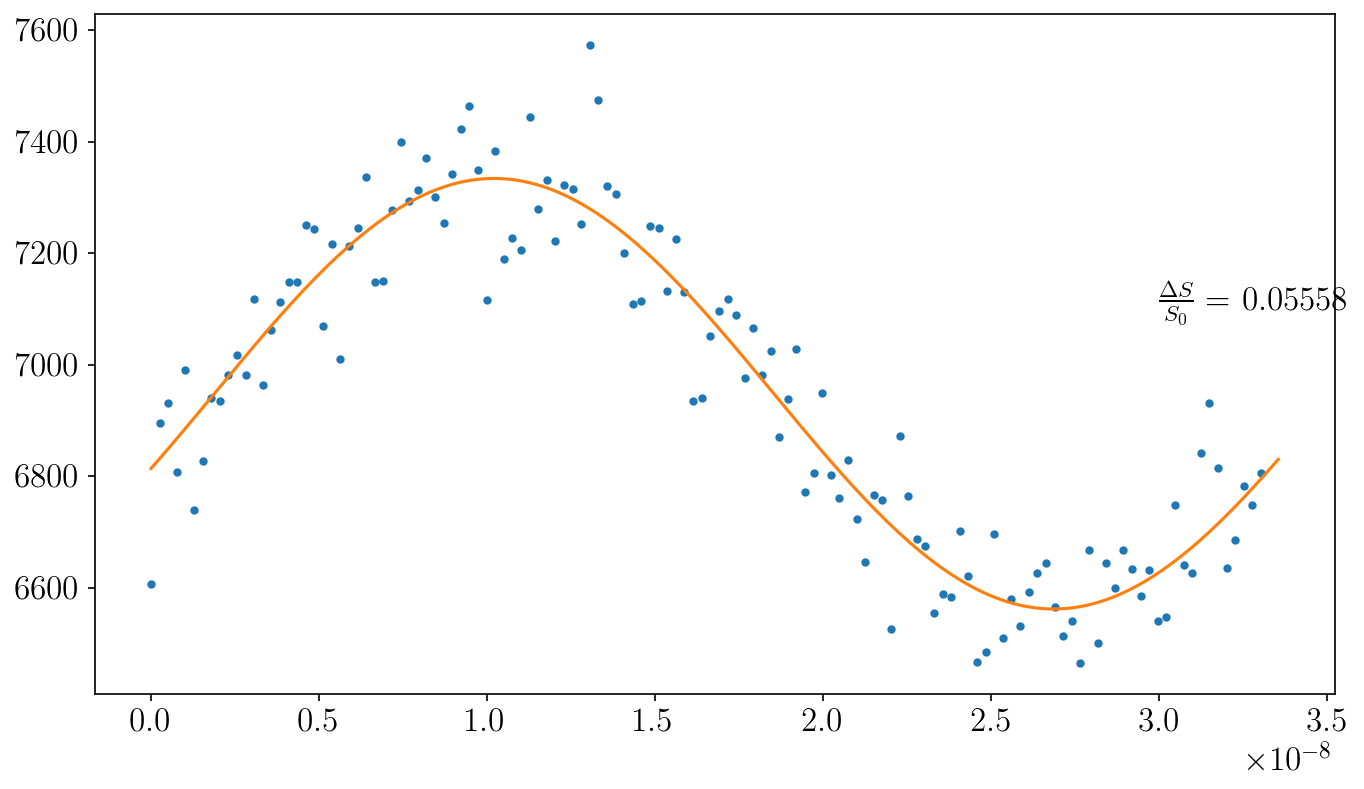

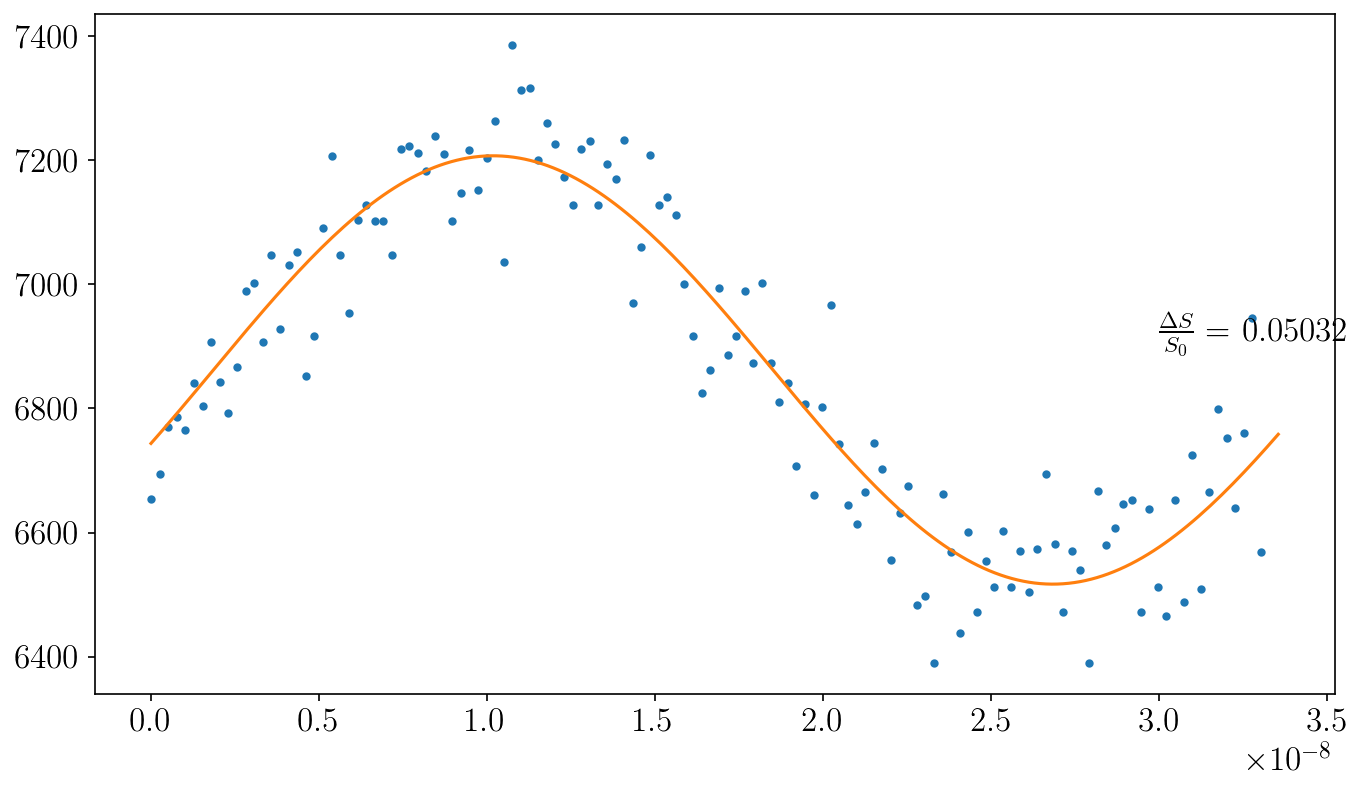

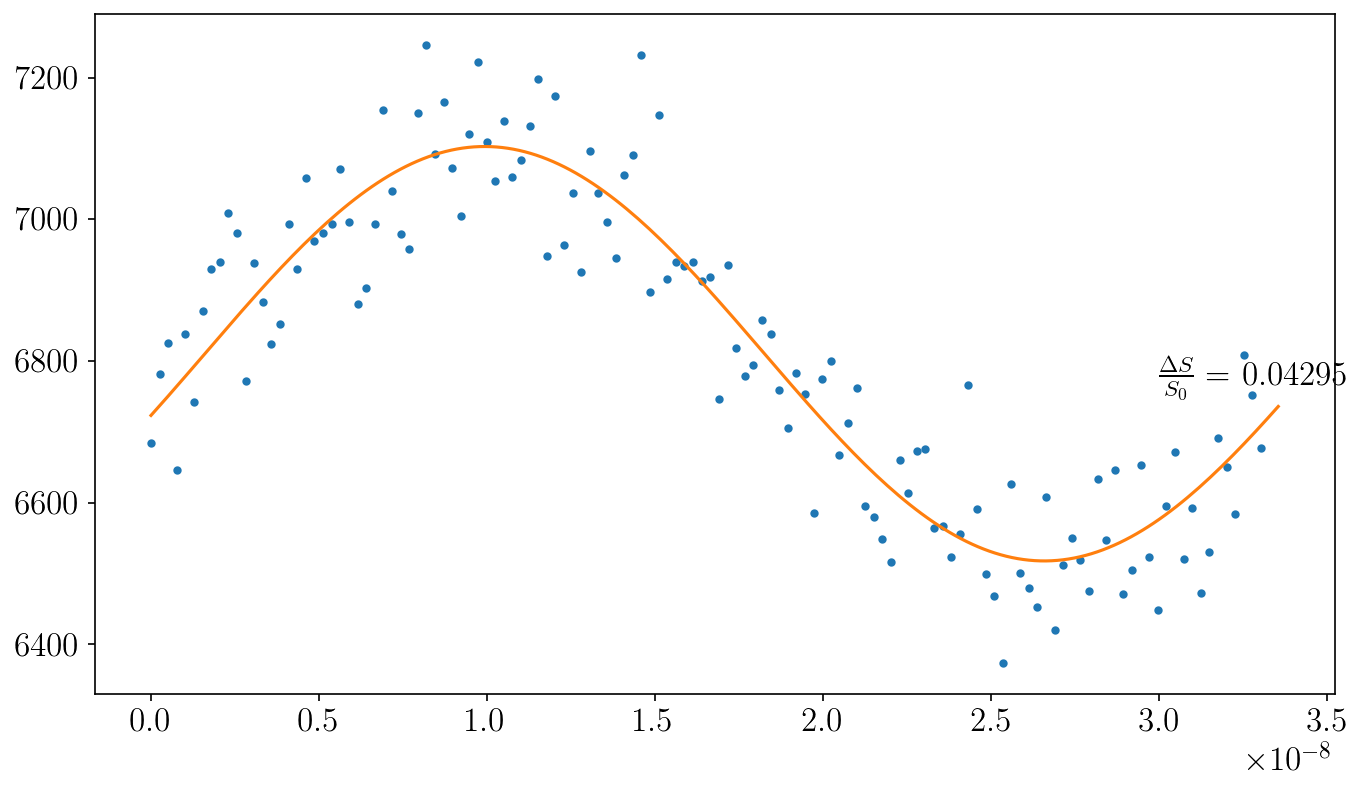

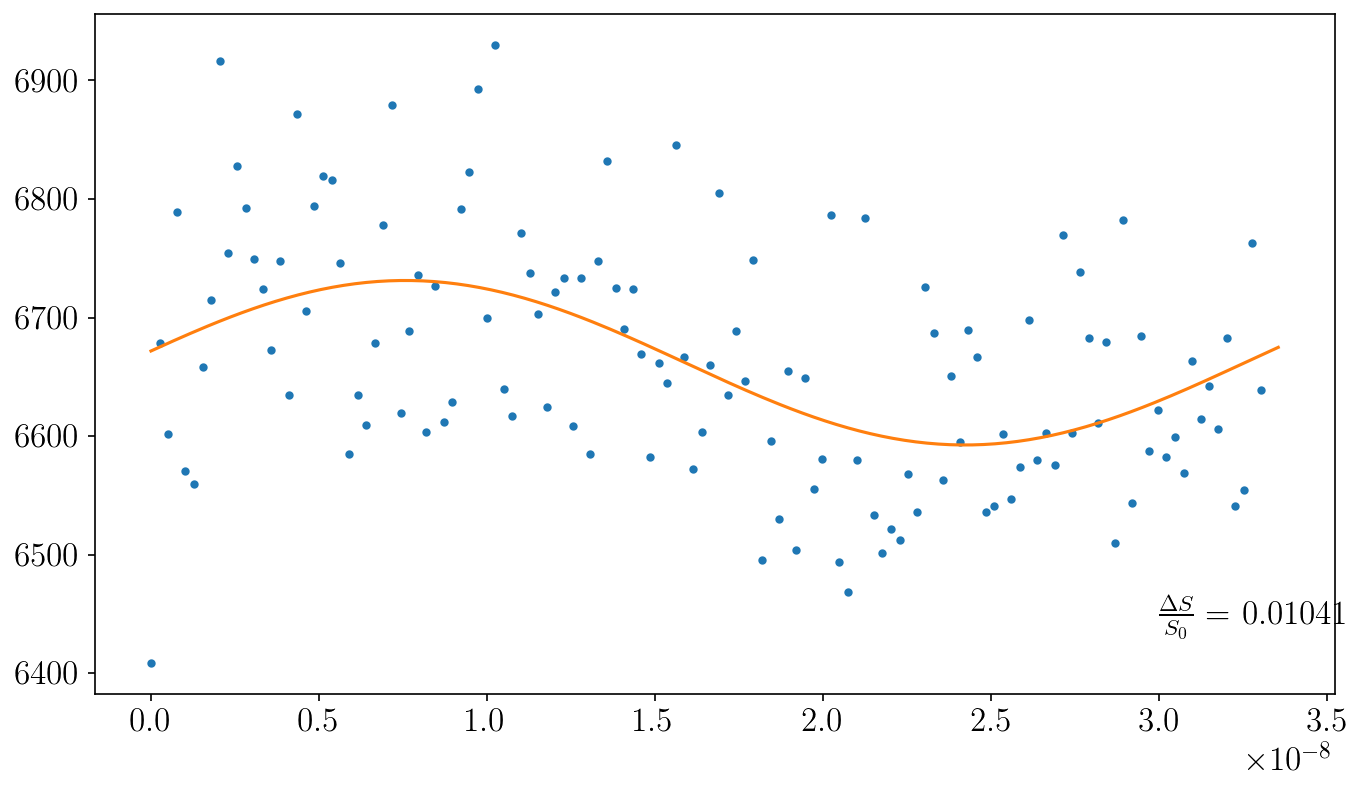

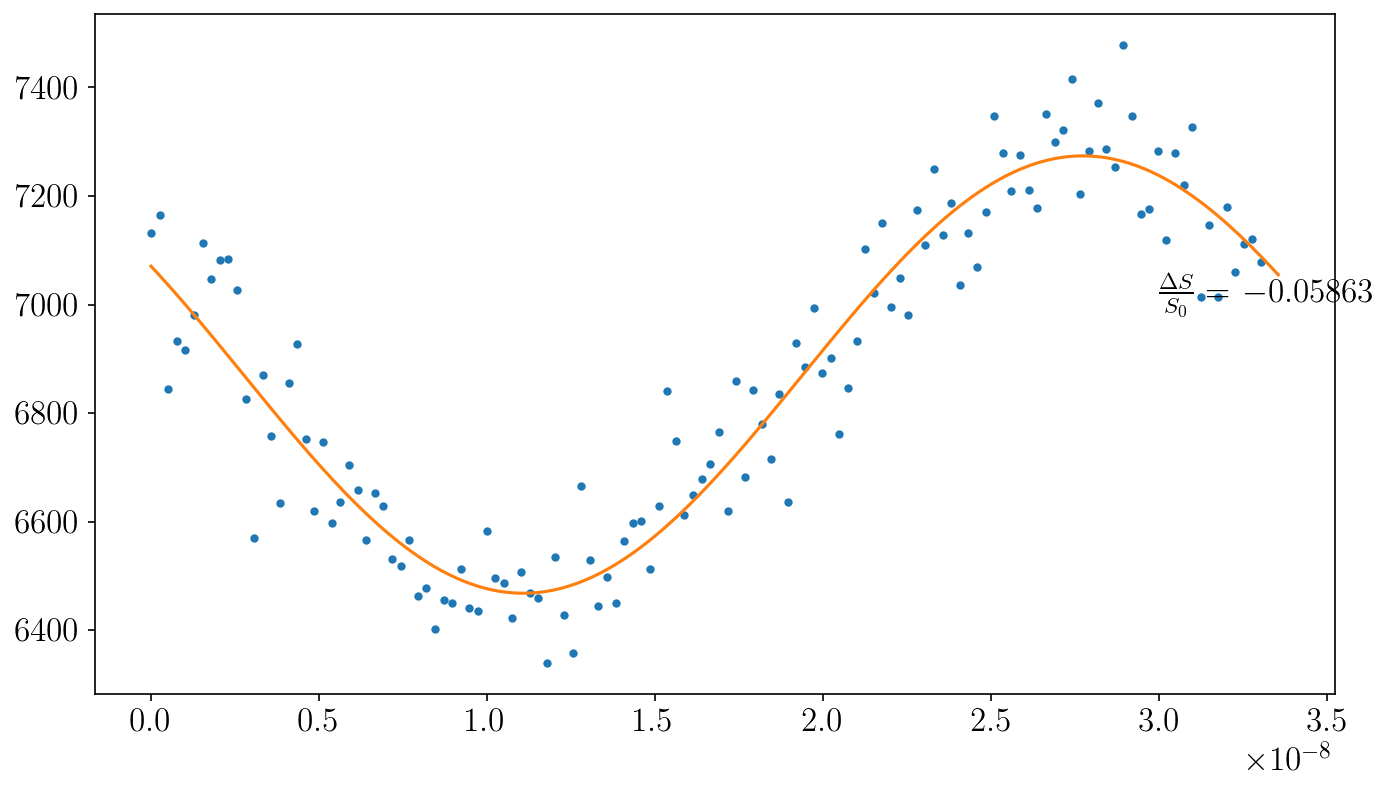

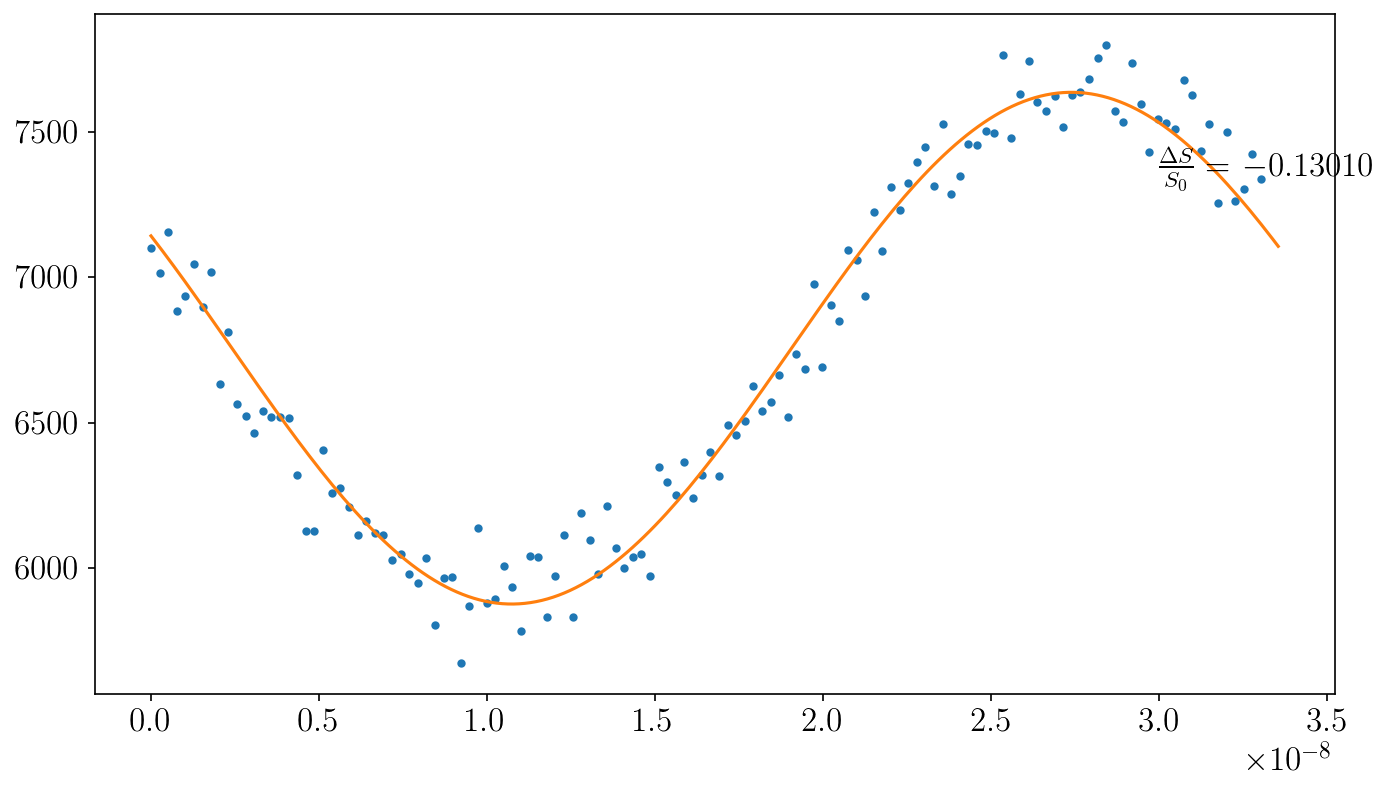

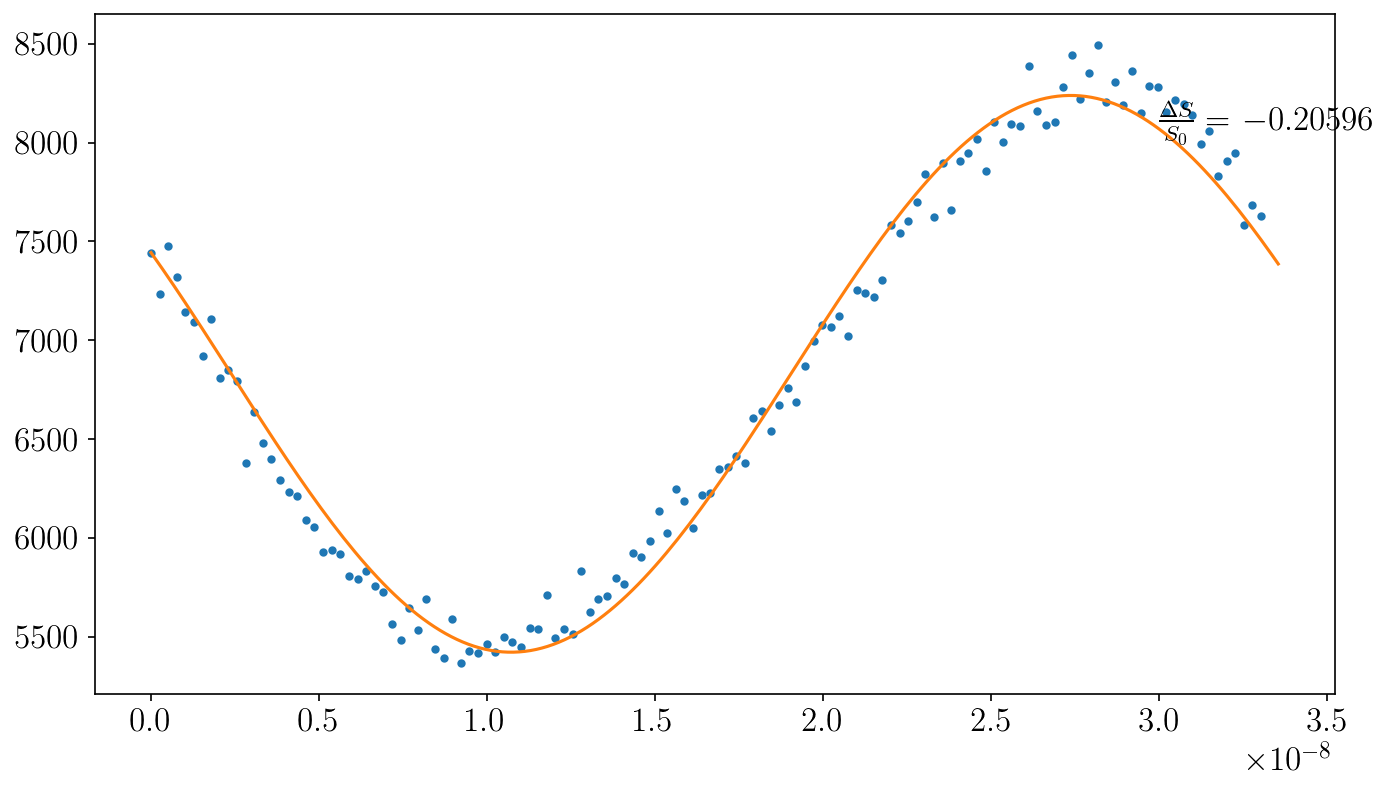

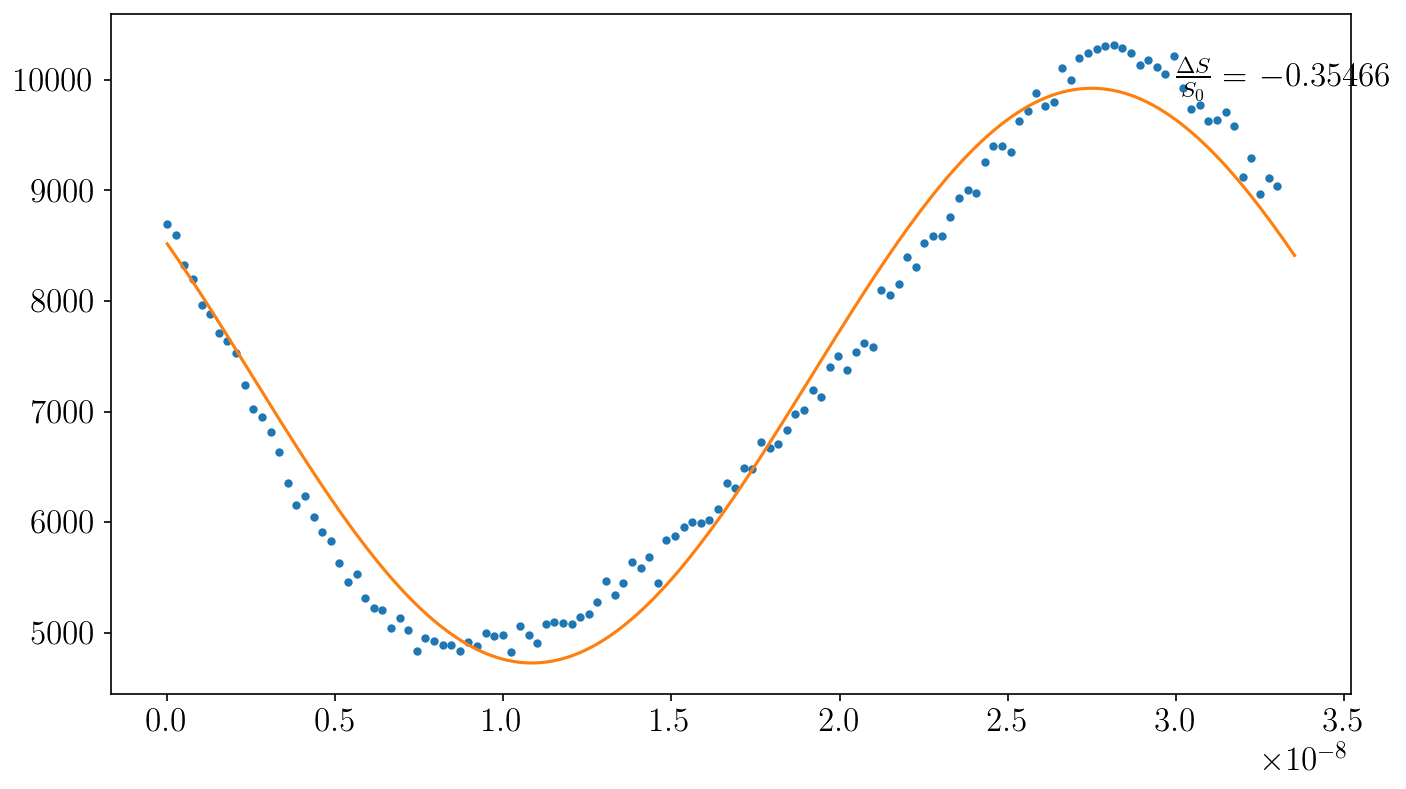

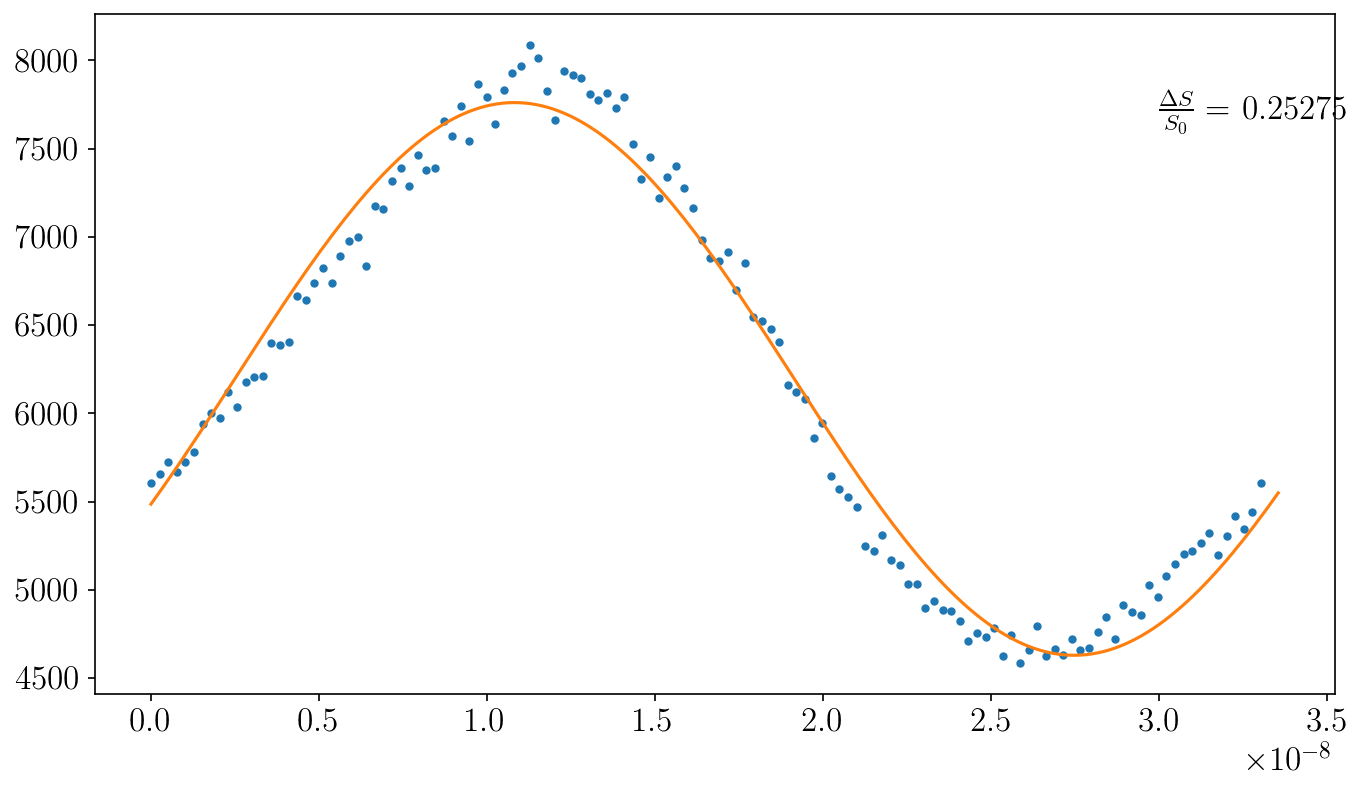

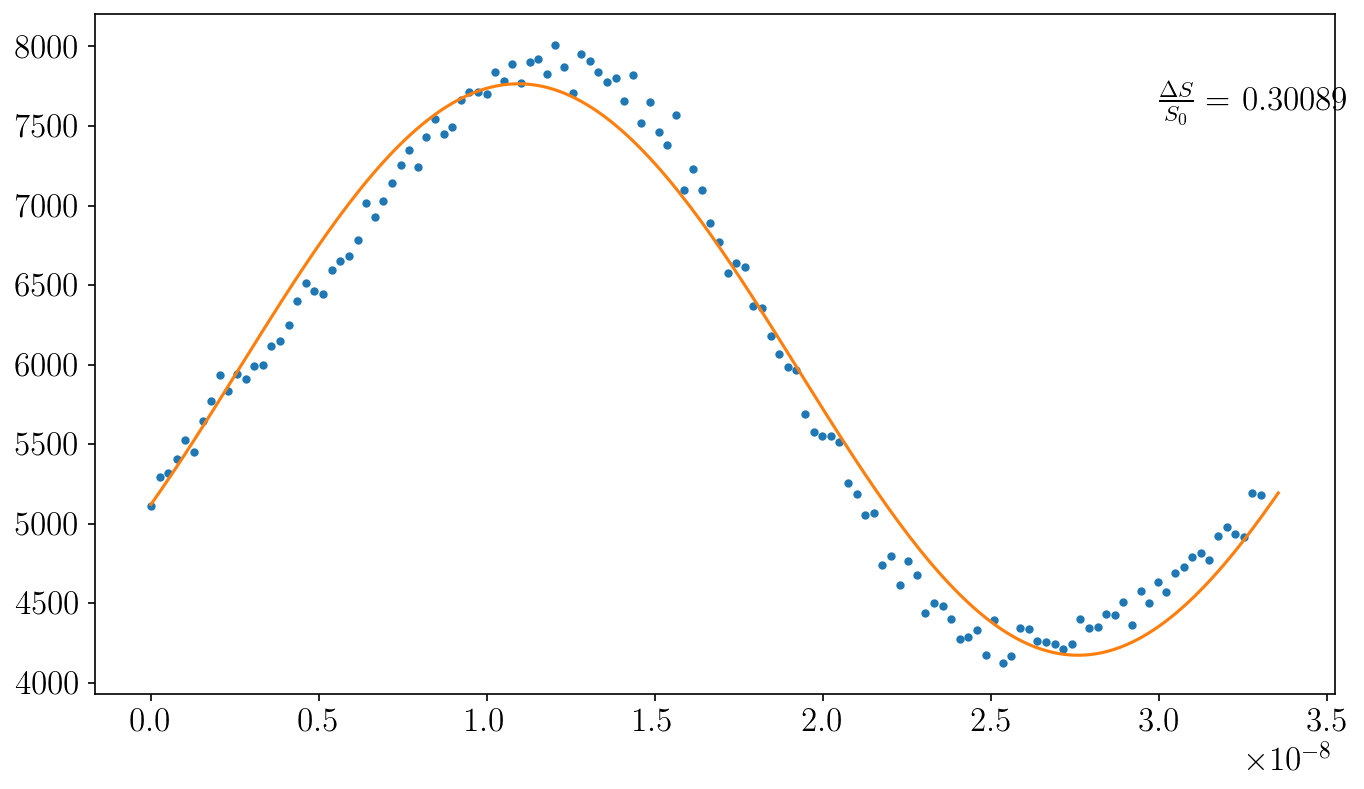

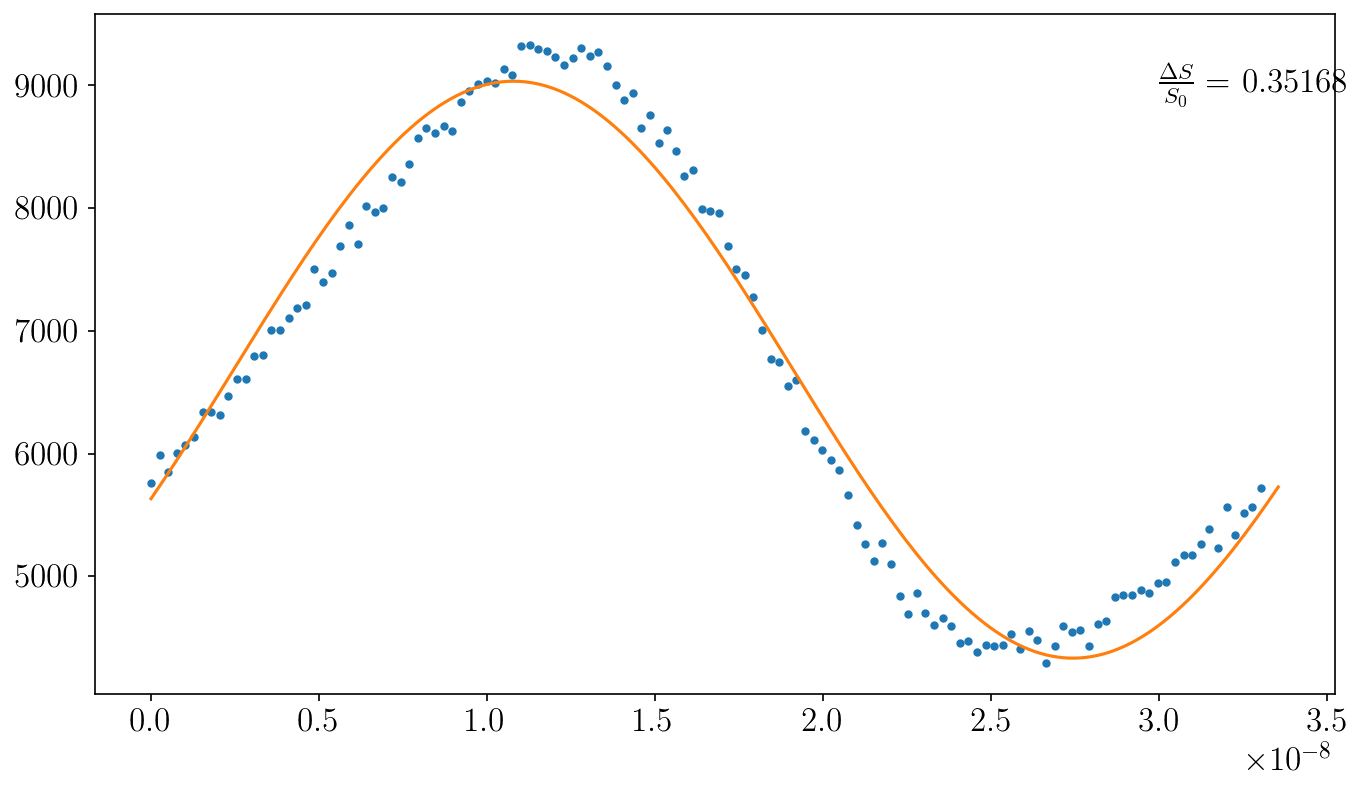

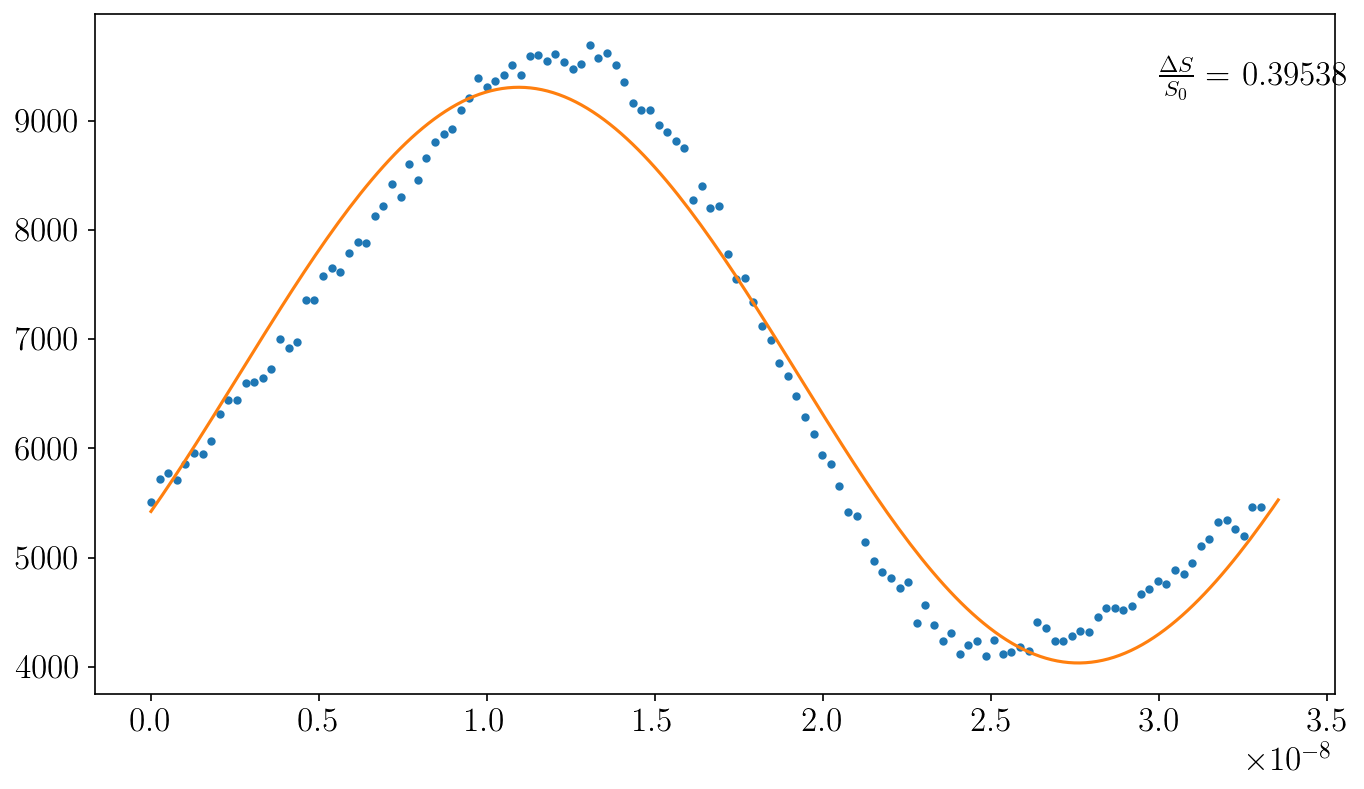

In [10]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func(x[:,i], Omega, time_fit)
    
    plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
    plt.plot(t_scale[:fotkor_shape[0]-2],fotkor_bezcond[:fotkor_shape[0]-2,i],'.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f}$'.format(x[1,i]/x[0,i])
    plt.text(3e-8, fotkor_bezcond[:,i].max()-500,text) 

Nejmenší MM vykazuje histogram s indexem 9. Na základě tohoto histogramu odhadnu varianci naměřených bodů. Nejprve od všech bodů histogramu odečtu nafitovanou sinusovku, abych dosáhl pokud možno nemodulovaných dat.

In [7]:
x0 = [fotkor_bezcond[:fotkor_shape[0]-2,9].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,9].max()
    -fotkor_bezcond[:fotkor_shape[0]-2,9].min() ), 1.5]

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,9], t_res) , ftol=1e-10, xtol=1e-10)

In [8]:
fotkor_bezcond_noMM = fotkor_bezcond[1:fotkor_shape[0]-2,9] - (fit_func(fit.x, Omega, t_scale[1:fotkor_shape[0]-2])) # data po odecteni modulace

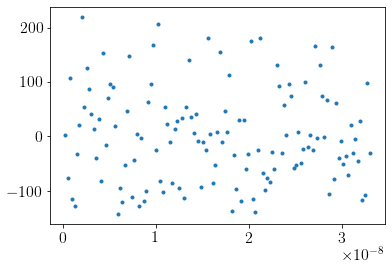

In [9]:
plt.plot(t_scale[1:fotkor_shape[0]-2],fotkor_bezcond_noMM, '.')

to vypada slibne. Ted odhadnu varianci techto bodu.

In [10]:
hist_sigma = np.std(fotkor_bezcond_noMM)
hist_sigma

86.0365751214755

Tuto hodnotu tedy budu predpokladat jako nejistotu bodu histogramu. Ještě ji zkusím ověřit na 8. histogramu.

In [11]:
x0 = [fotkor_bezcond[:fotkor_shape[0]-2,8].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,8].max()
    -fotkor_bezcond[:fotkor_shape[0]-2,8].min() ), 1.5]

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,8], t_res) , ftol=1e-10, xtol=1e-10)
fotkor_bezcond_noMM = fotkor_bezcond[1:fotkor_shape[0]-2,8] - (fit_func(fit.x, Omega, t_scale[1:fotkor_shape[0]-2])) # data po odecteni modulace
np.std(fotkor_bezcond_noMM)

81.09953614071743

V poradku.

## Fitování histogramů včetně odhadu nejistot

Proces fitování musím upravit tak, abych mohl odhadnout nejistoty, tzn. přidávám váhy. Dále pak budu do grafů přidávat errorbary.

In [29]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

def fit_resid_weight_transform(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S/S_0, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0]*(1 + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2]) )
    return( np.sqrt(W_vec) * (S - S_fit) )

def fit_resid_weight_transform_jac(x,W_vec, Omega, S, time_step):
    
    len_S = len(S)
    
    return(  np.transpose( -np.sqrt(W_vec)*[1 + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2]), 
                       x[0]*np.cos(Omega * time_step * np.arange(0, len_S) + x[2]),
                      x[0]*x[1]*np.cos(Omega * time_step * np.arange(0, len_S) + x[2])*np.sin(Omega * time_step * np.arange(0, len_S) + x[2])] ) )

In [36]:
#from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []

W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)
#W_vec = 1/30**2 * np.ones(fotkor_shape[0]-2)
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), 1.5]
#     W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
#     fit = least_squares(fit_resid_weight_transform,x0, args=(W_vec,Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10,
#                        jac=fit_resid_weight_transform_jac)

    #---- odhad nejistot parametru----
    jac = fit.jac
    C = np.linalg.inv( np.matmul( np.transpose(jac), np.matmul( np.diag(W_vec), jac ) ) )  # variancni-kovariancni matice
    resid_sq = fit.fun**2   # residua na druhou
    g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
    #-------------------------------
    
    
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    #---- sigma delta s ku s
    S0 = fit.x[0]
    DeltaS = fit.x[1]
    Delta_S_S_ratio_sigma.append(np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )
    
    
DeltaS = np.array(DeltaS)
Delta_S_S_ratio_sigma = np.array(Delta_S_S_ratio_sigma)

In [37]:
print(DeltaS_S_ratio[9])
print(Delta_S_S_ratio_sigma[9])
print(voltages_bezcond[9,:])

-0.010412359234912974
0.09746333148292263
[575. 425.  39.  50.]


In [38]:
print(x[1,9])
print(sigmas[1,9])

-69.36638393431801
917.9028847145369


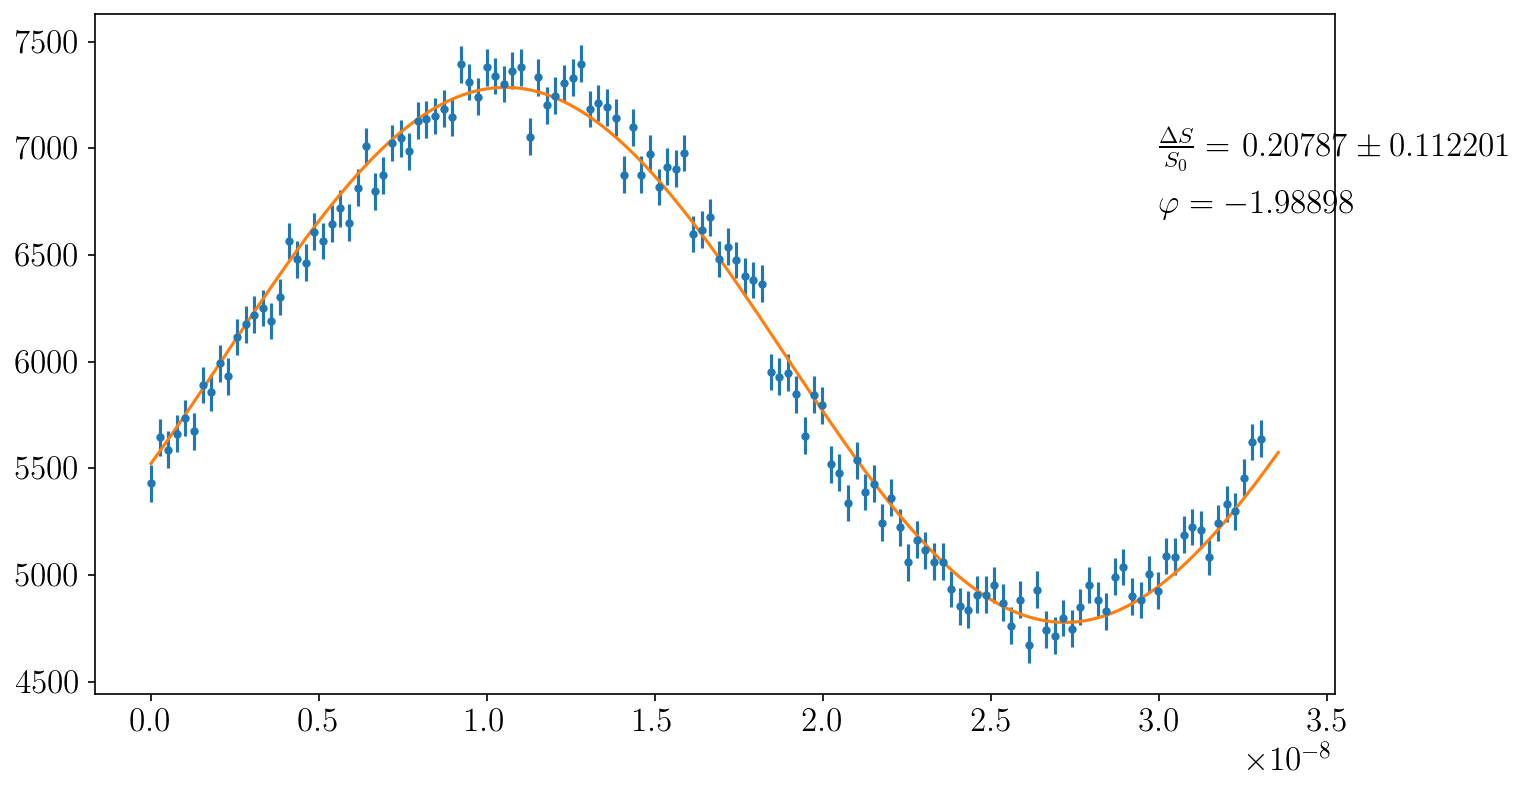

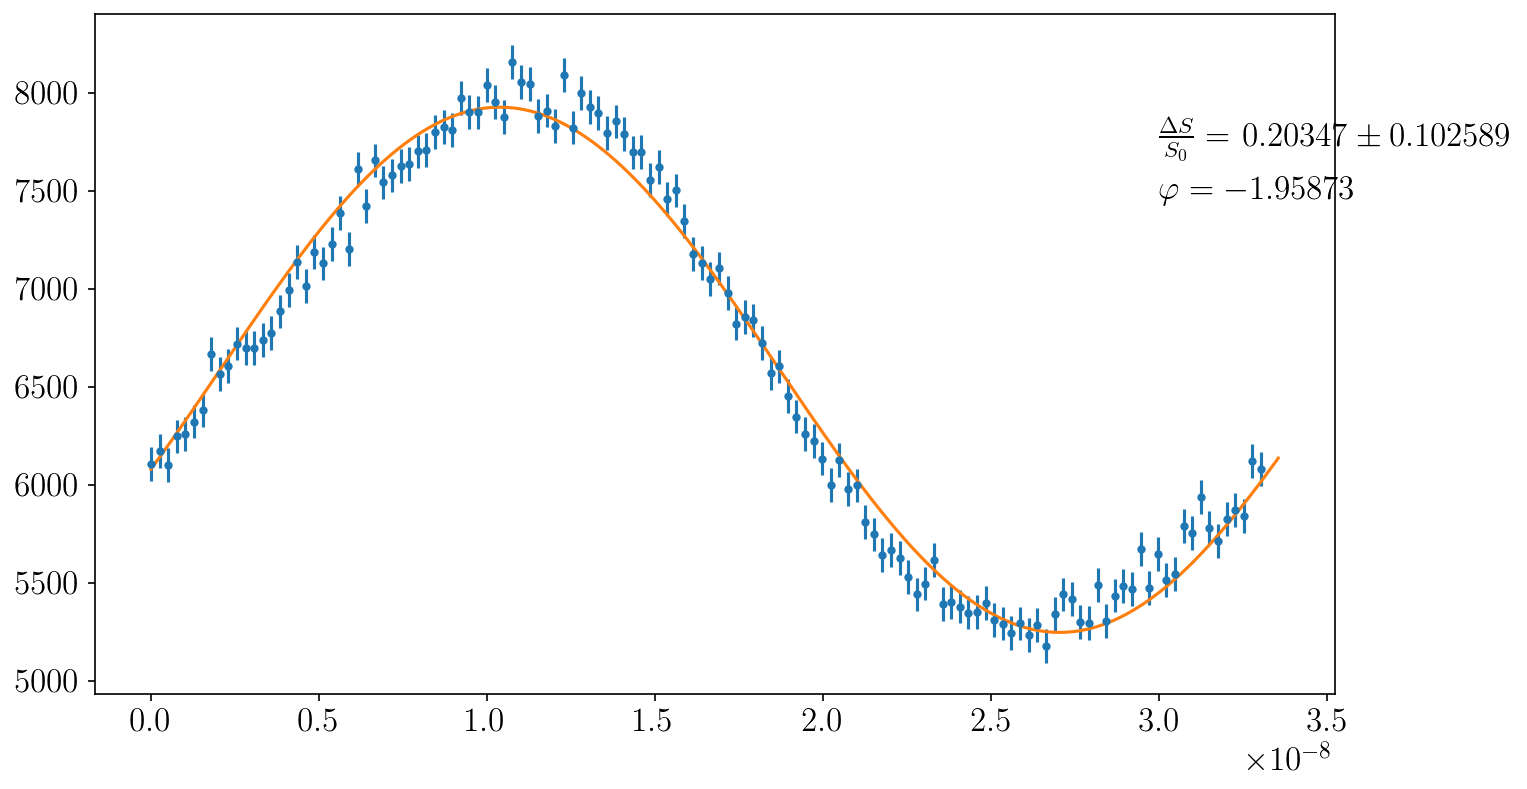

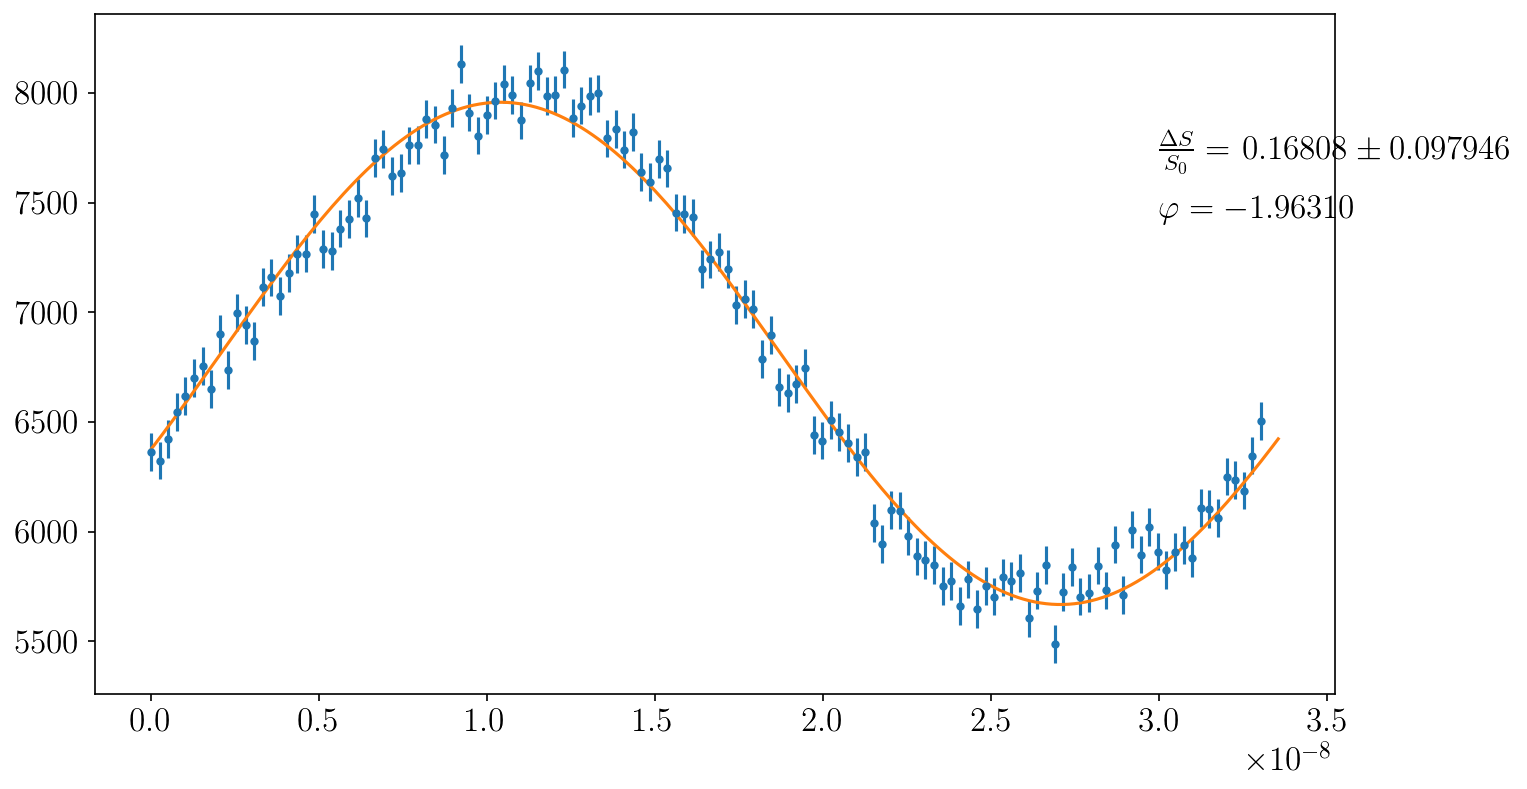

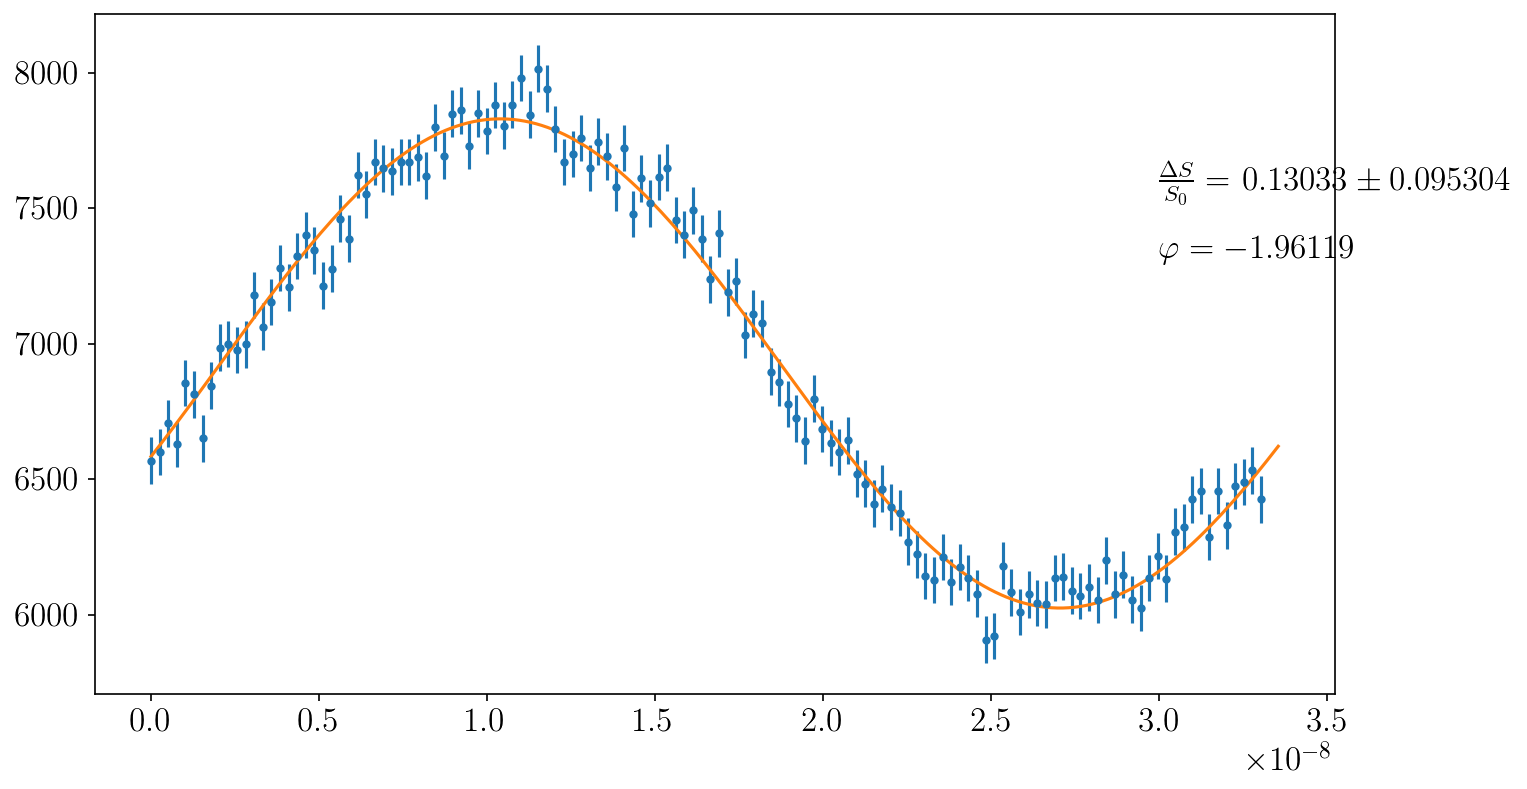

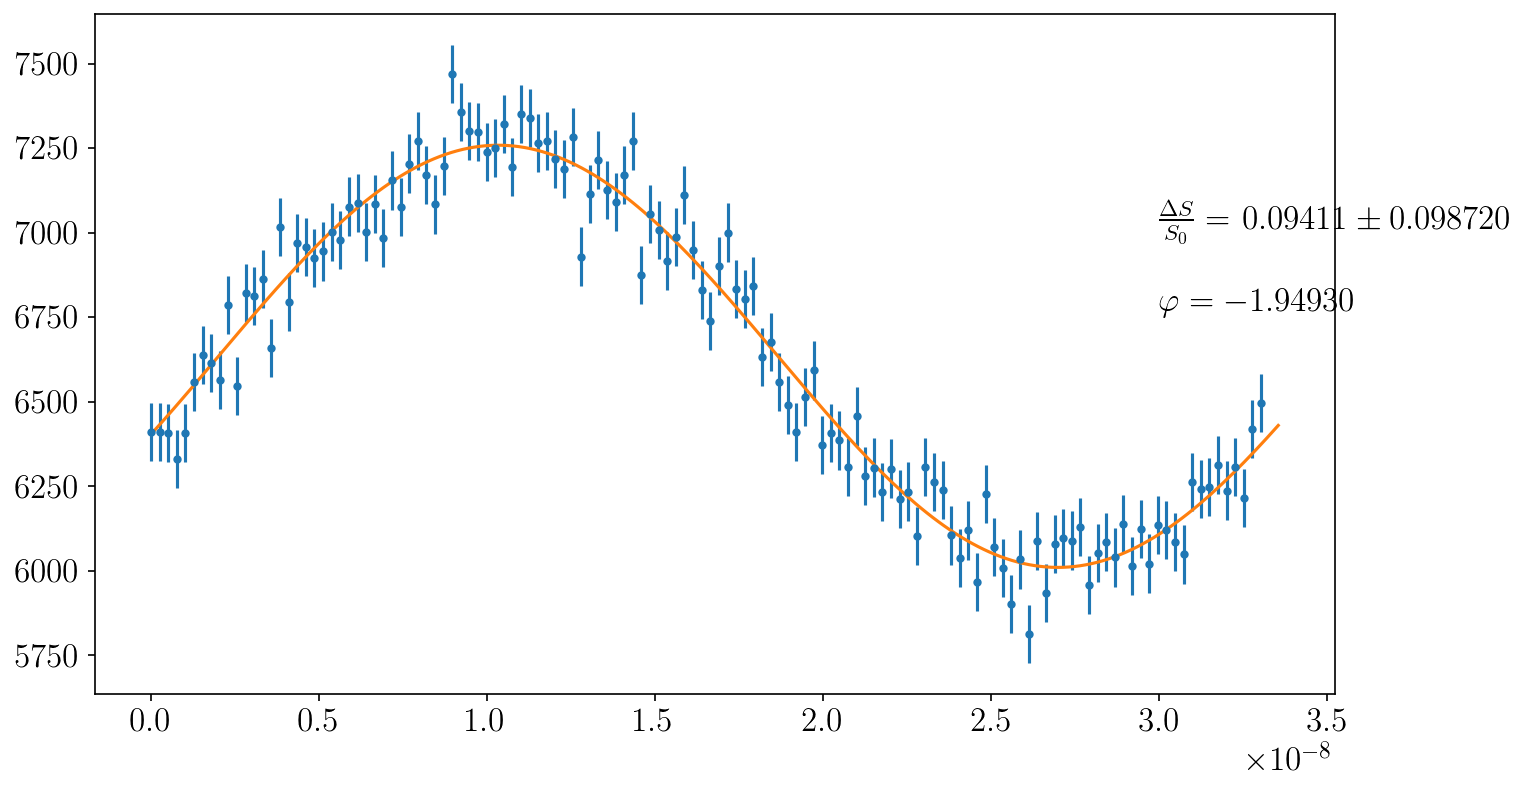

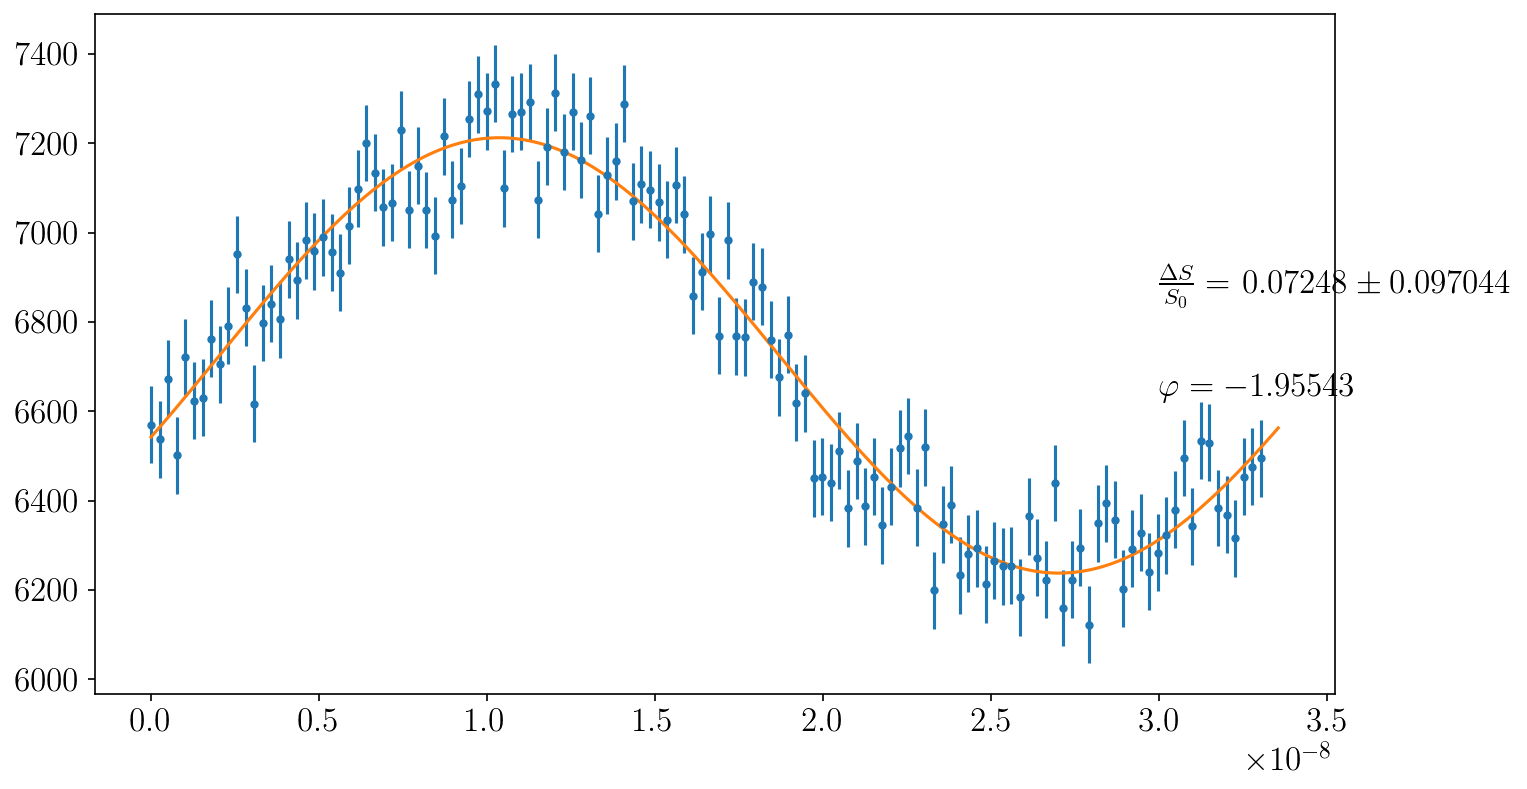

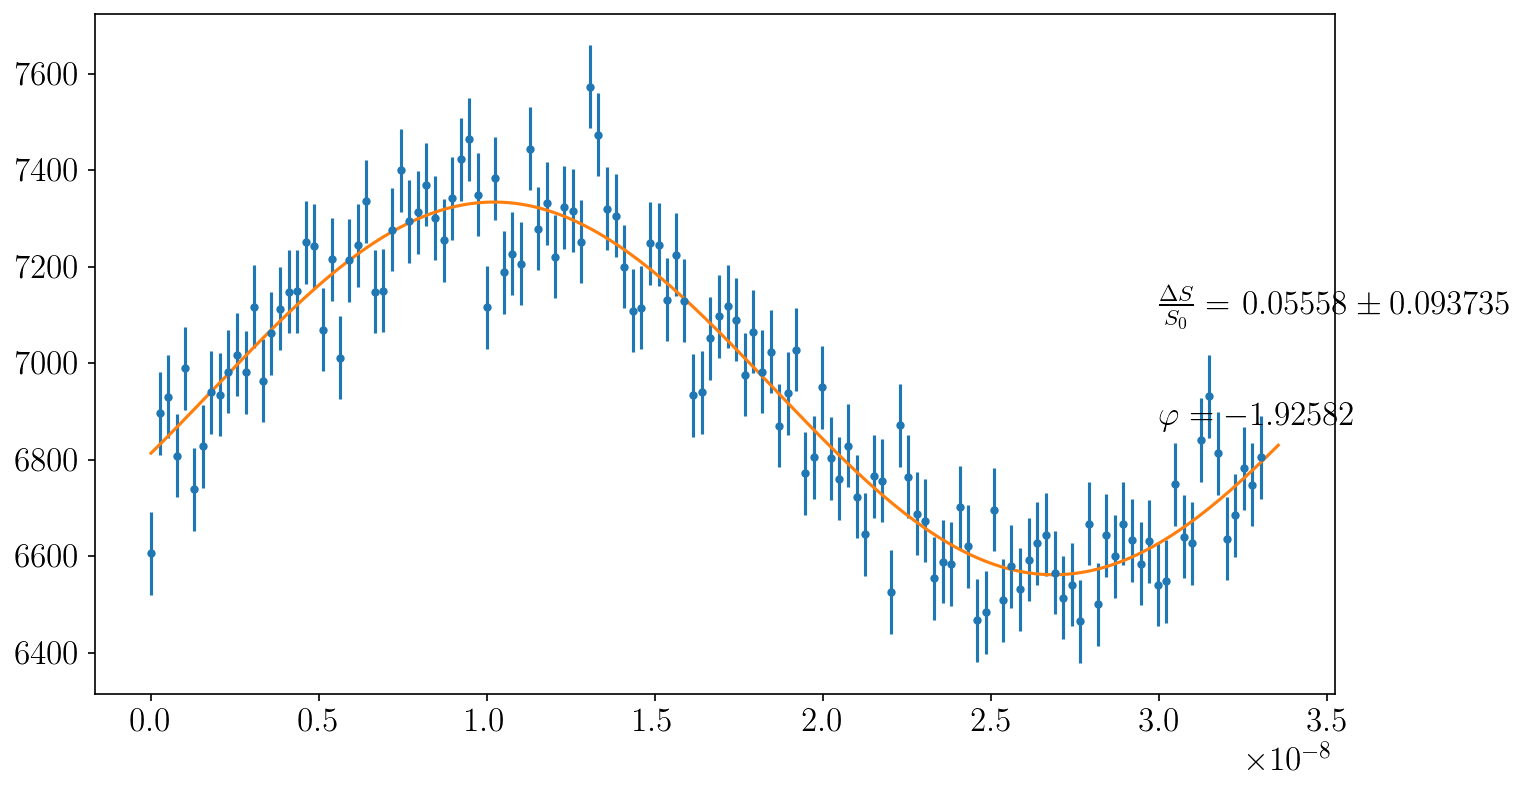

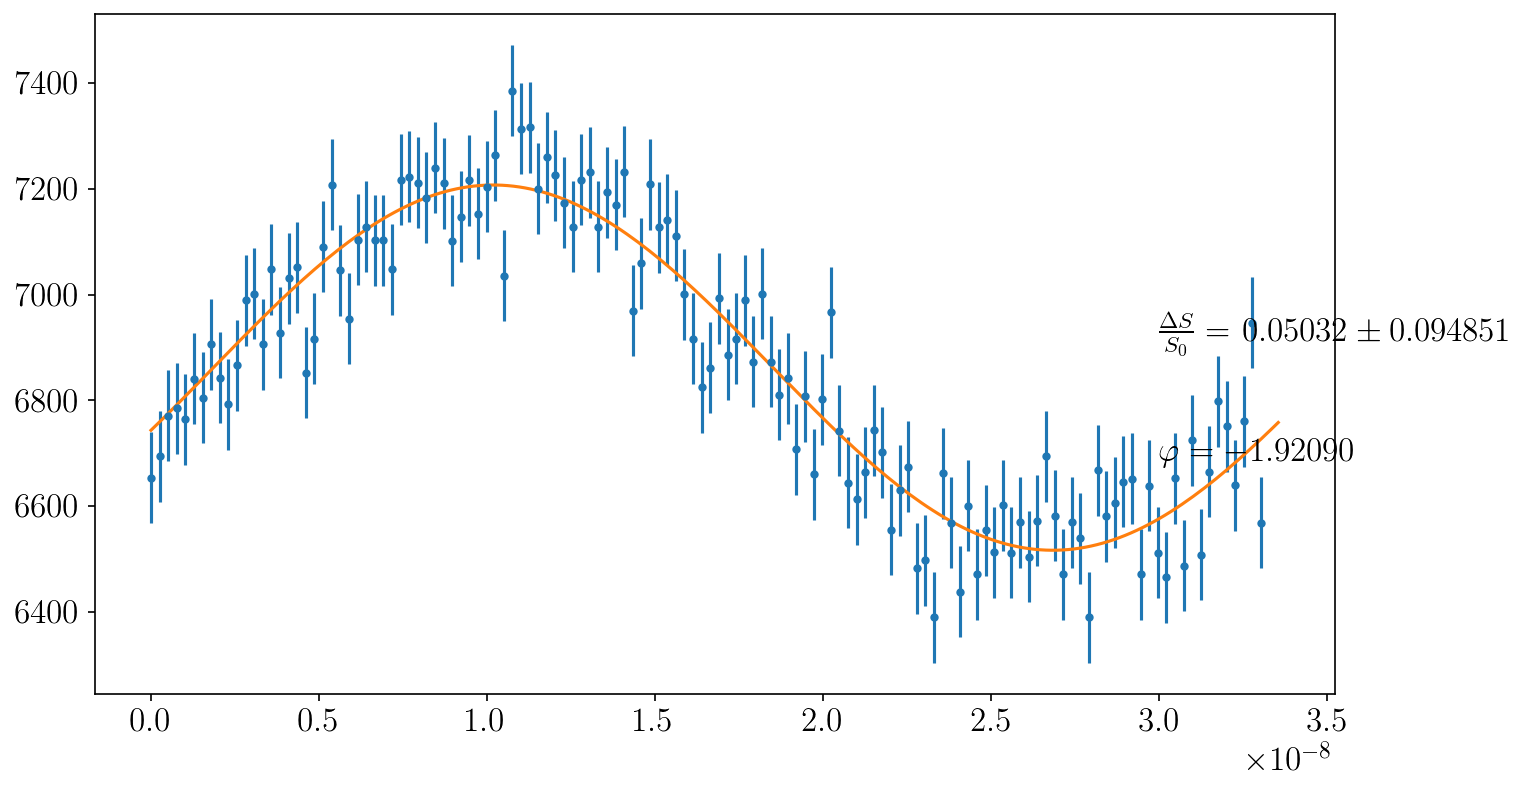

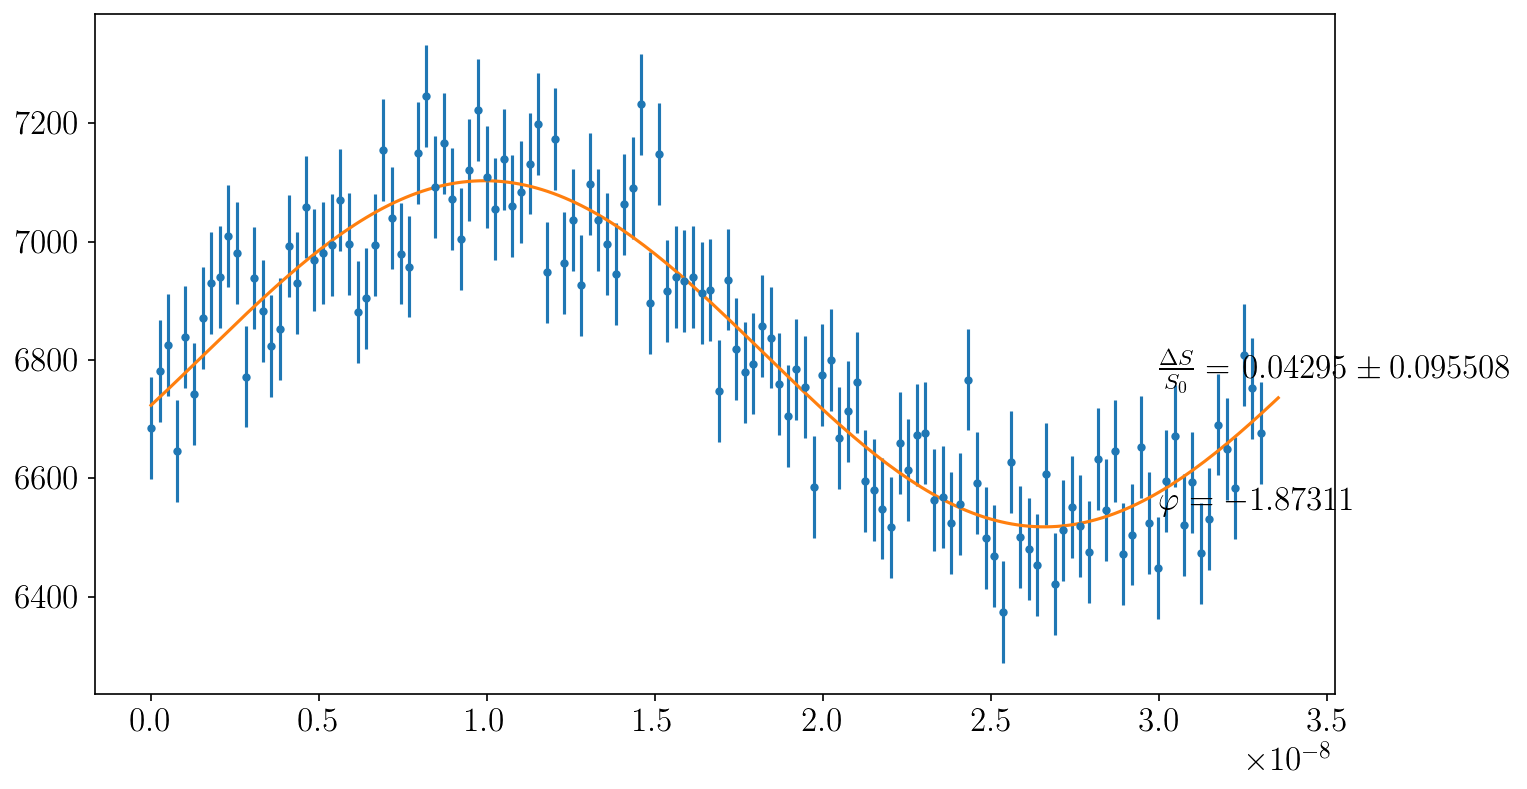

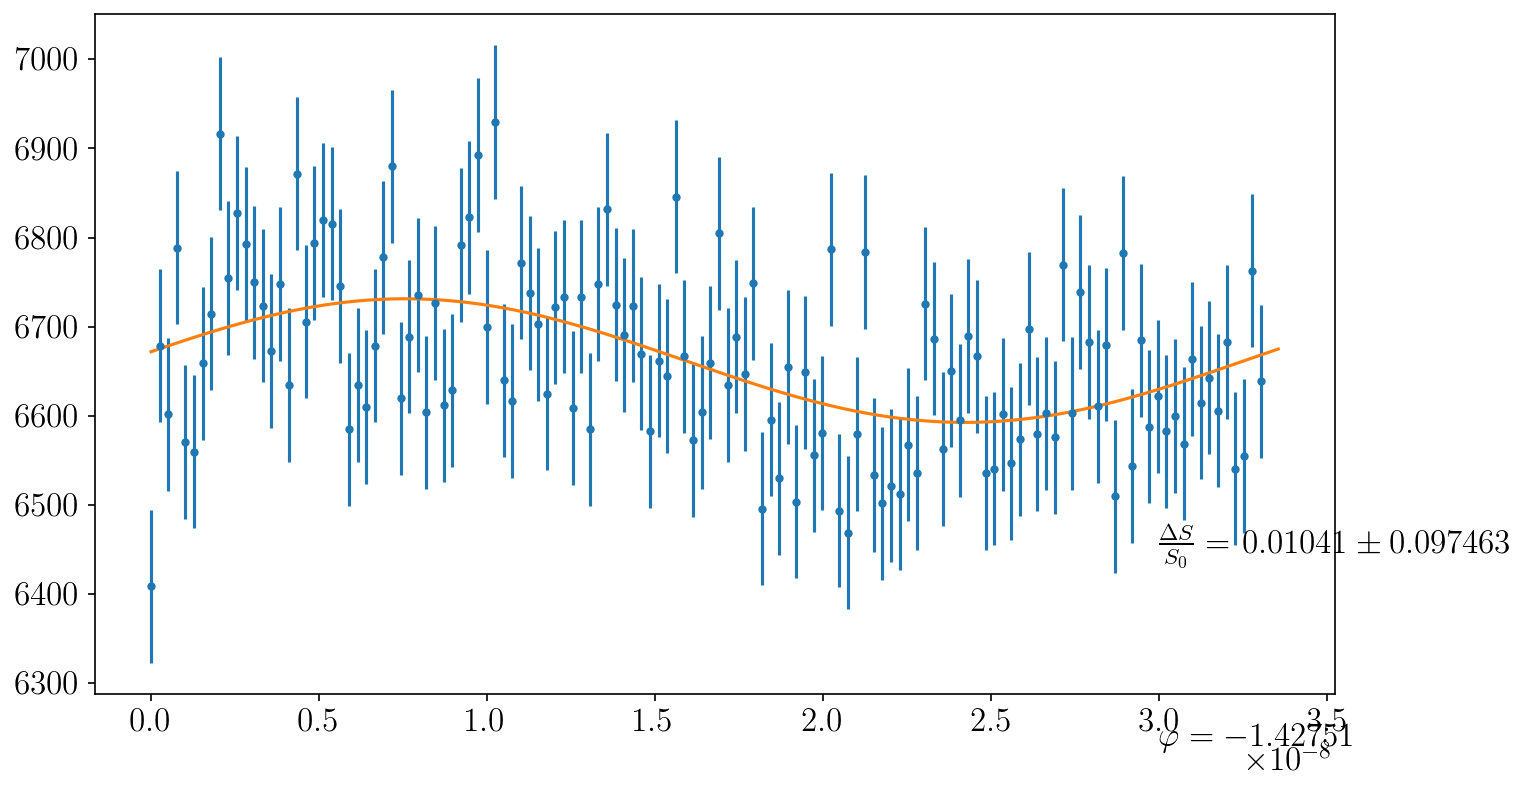

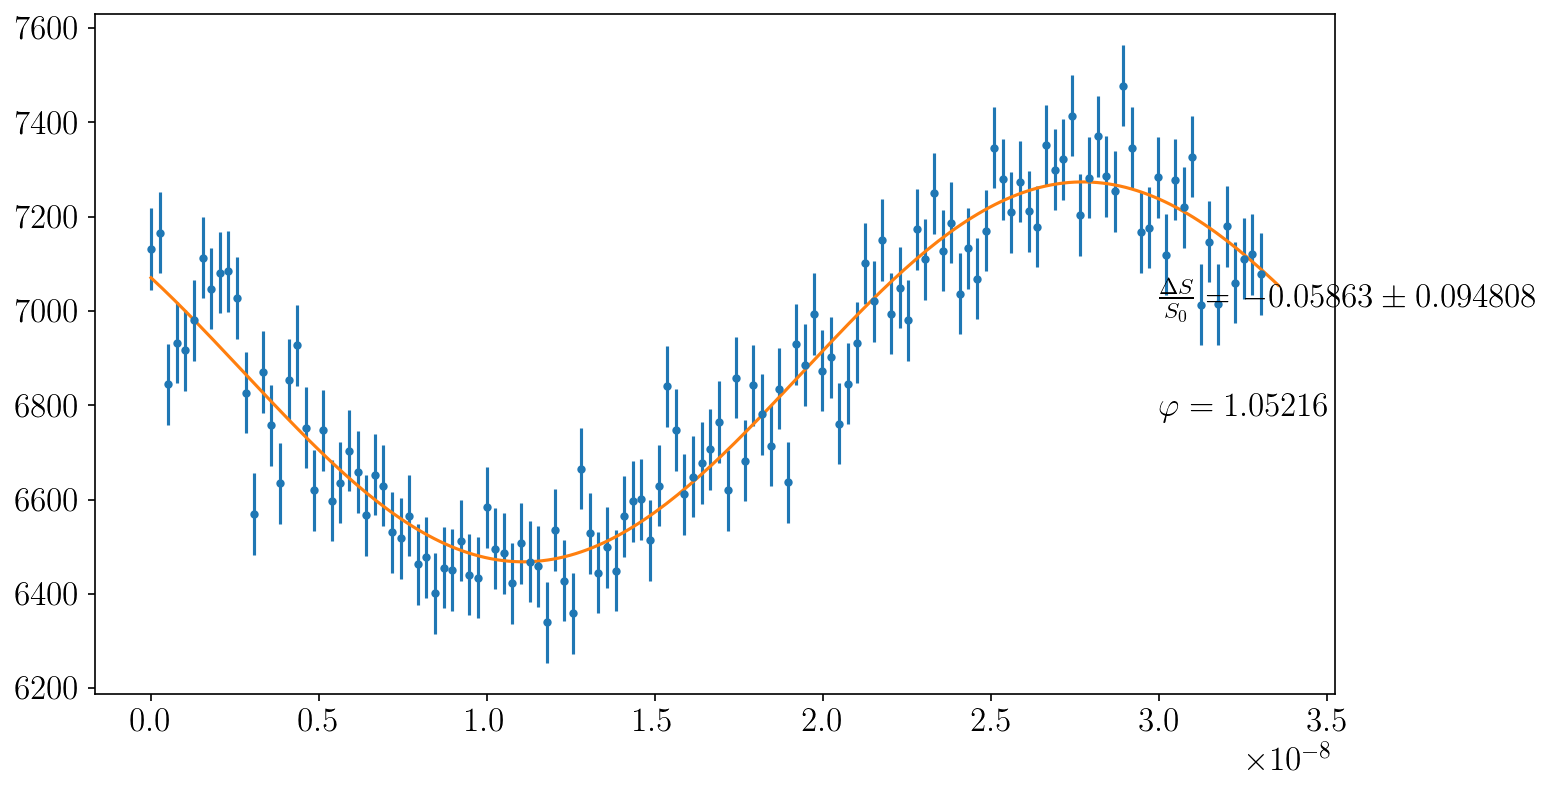

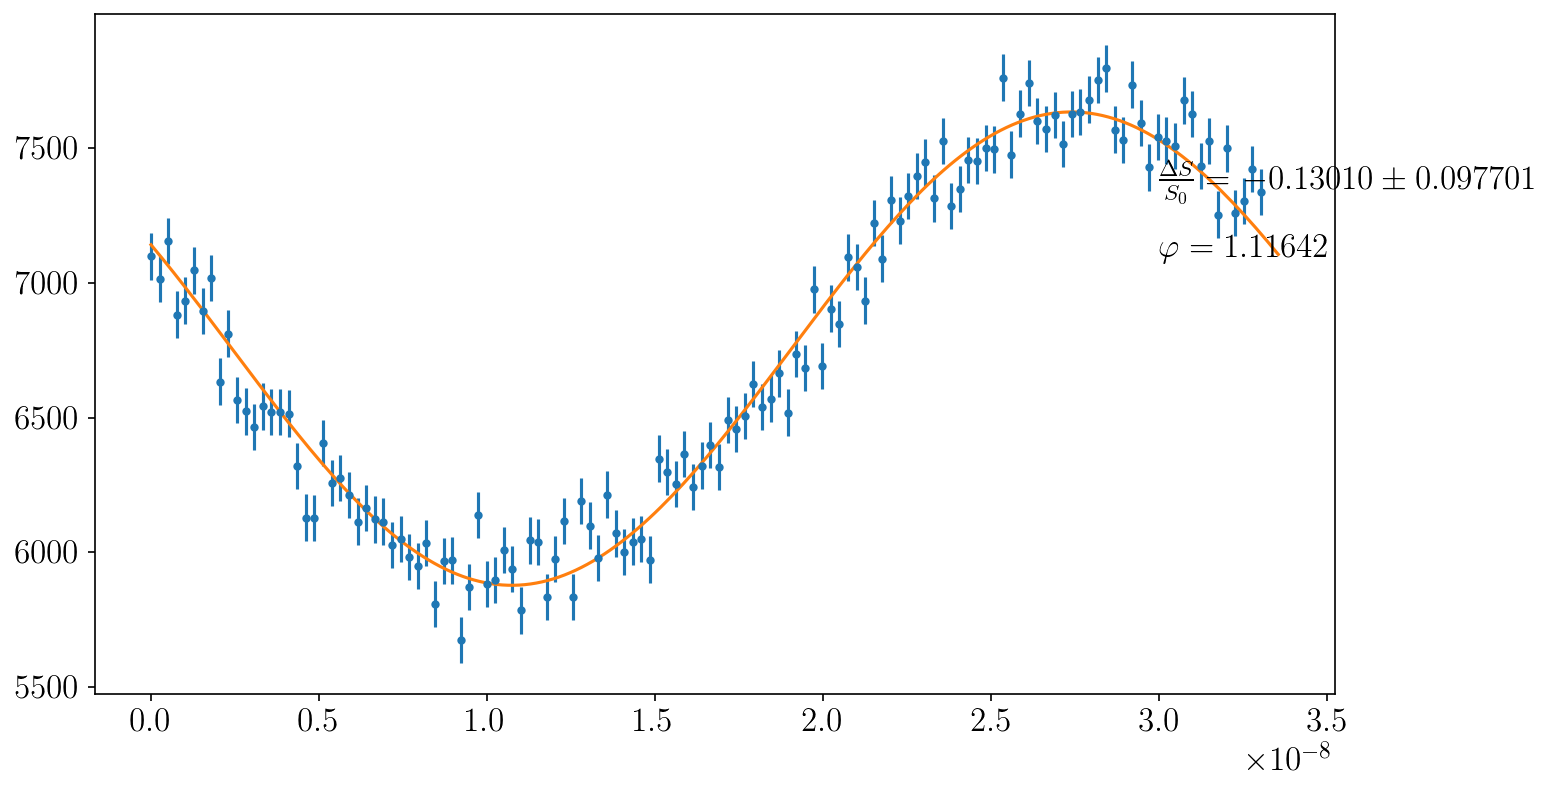

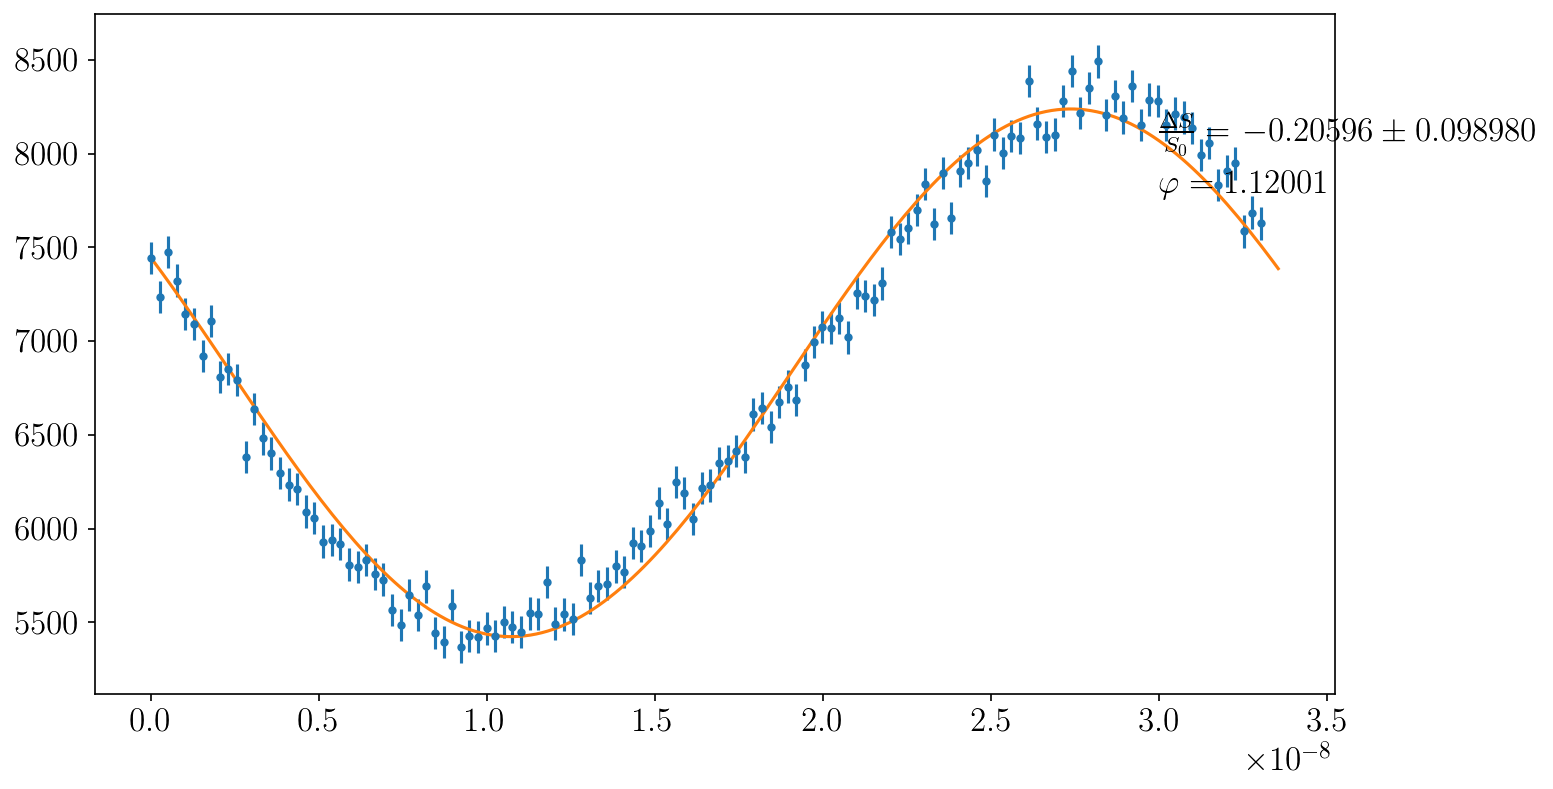

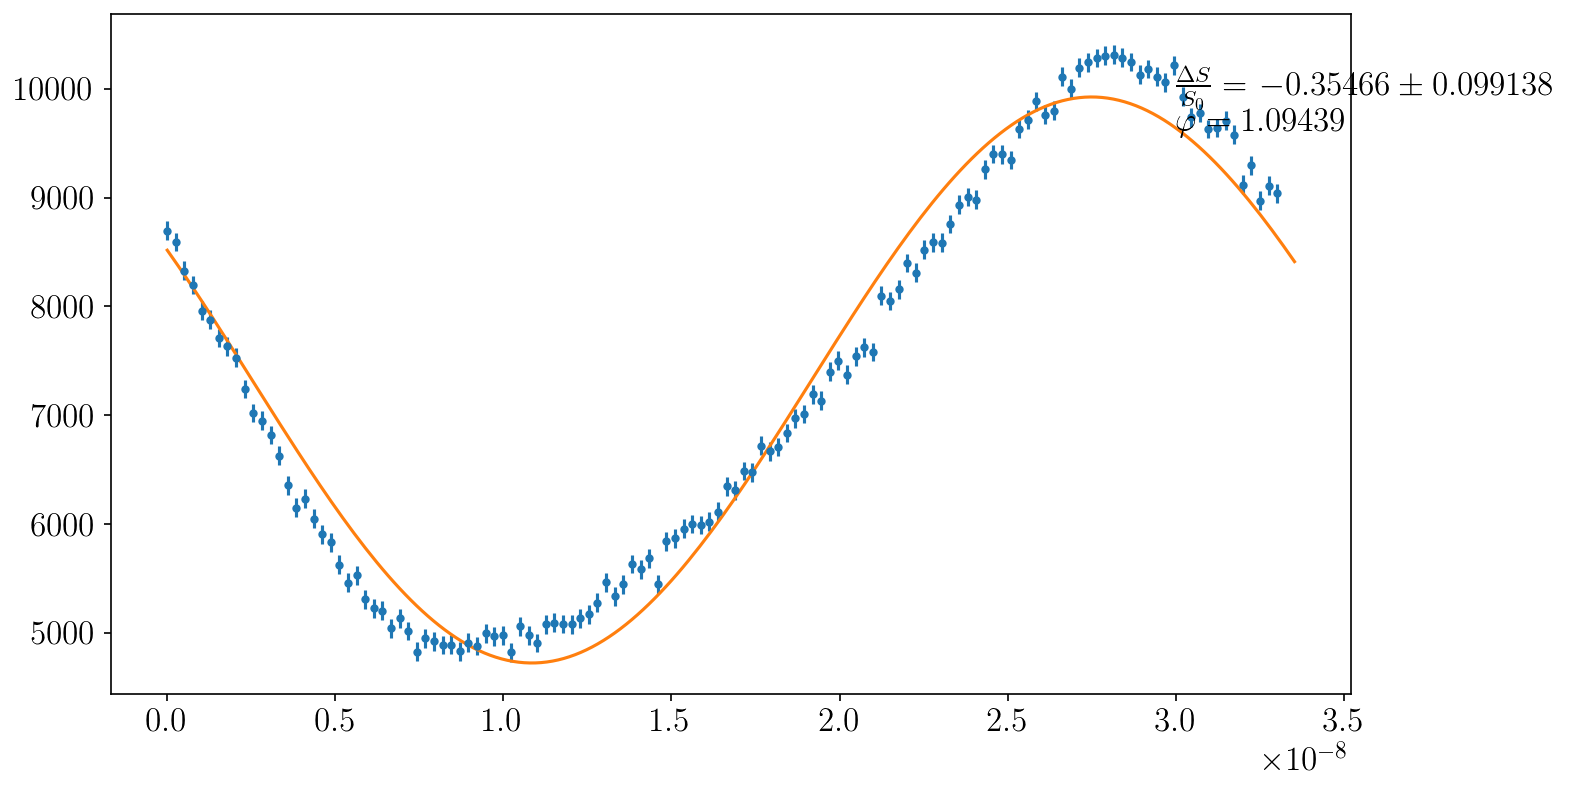

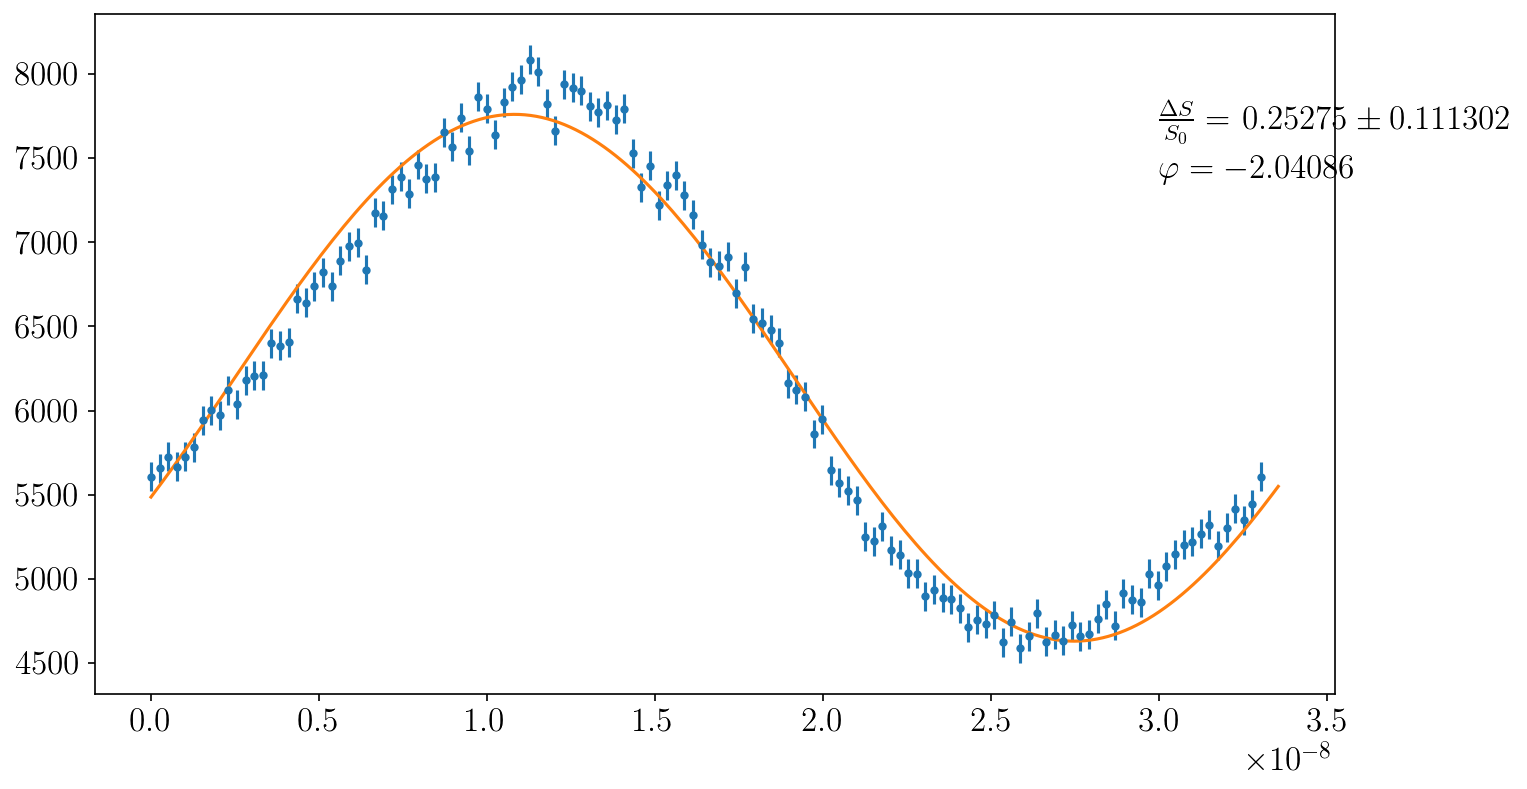

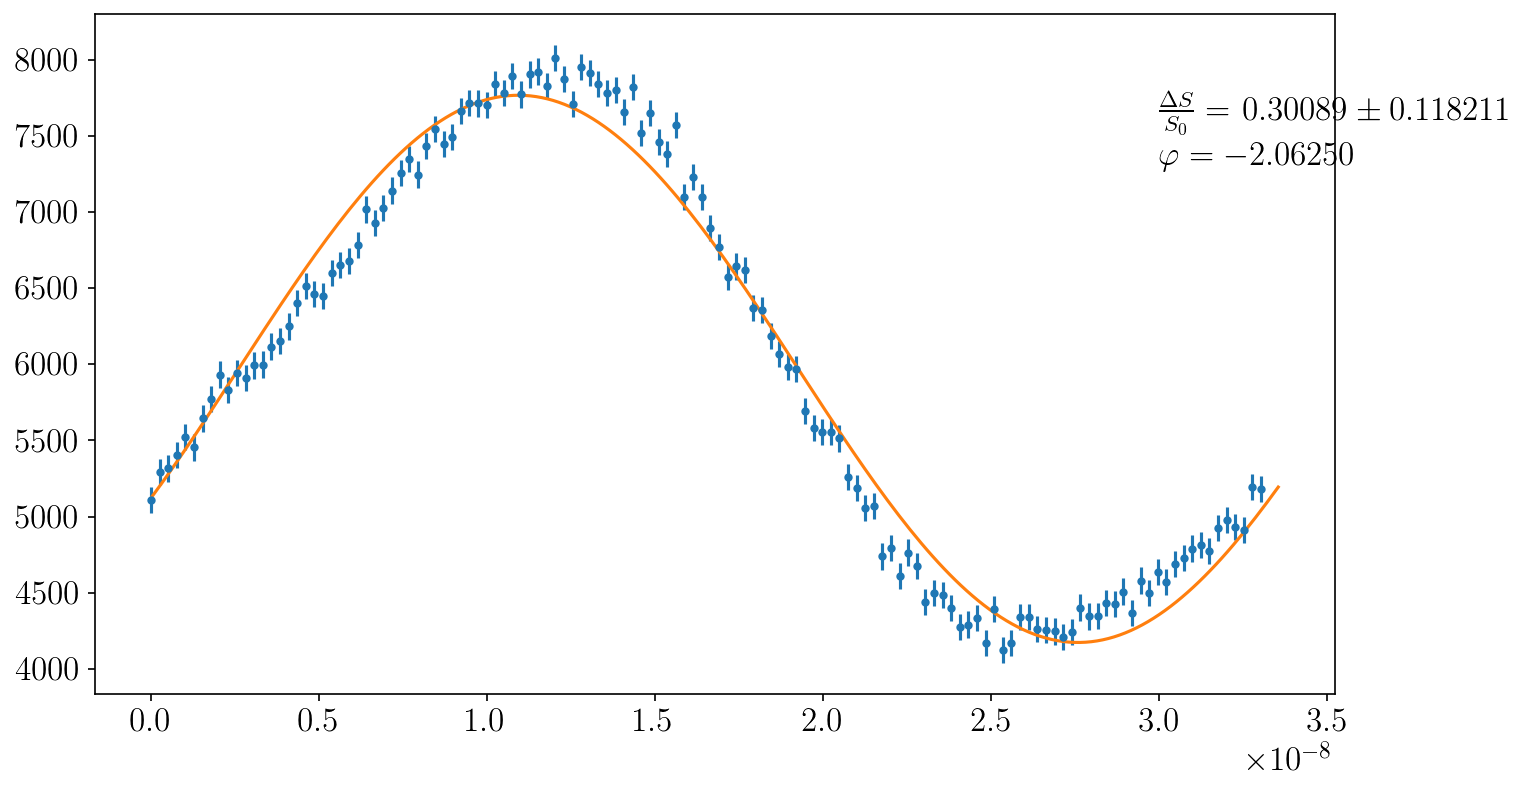

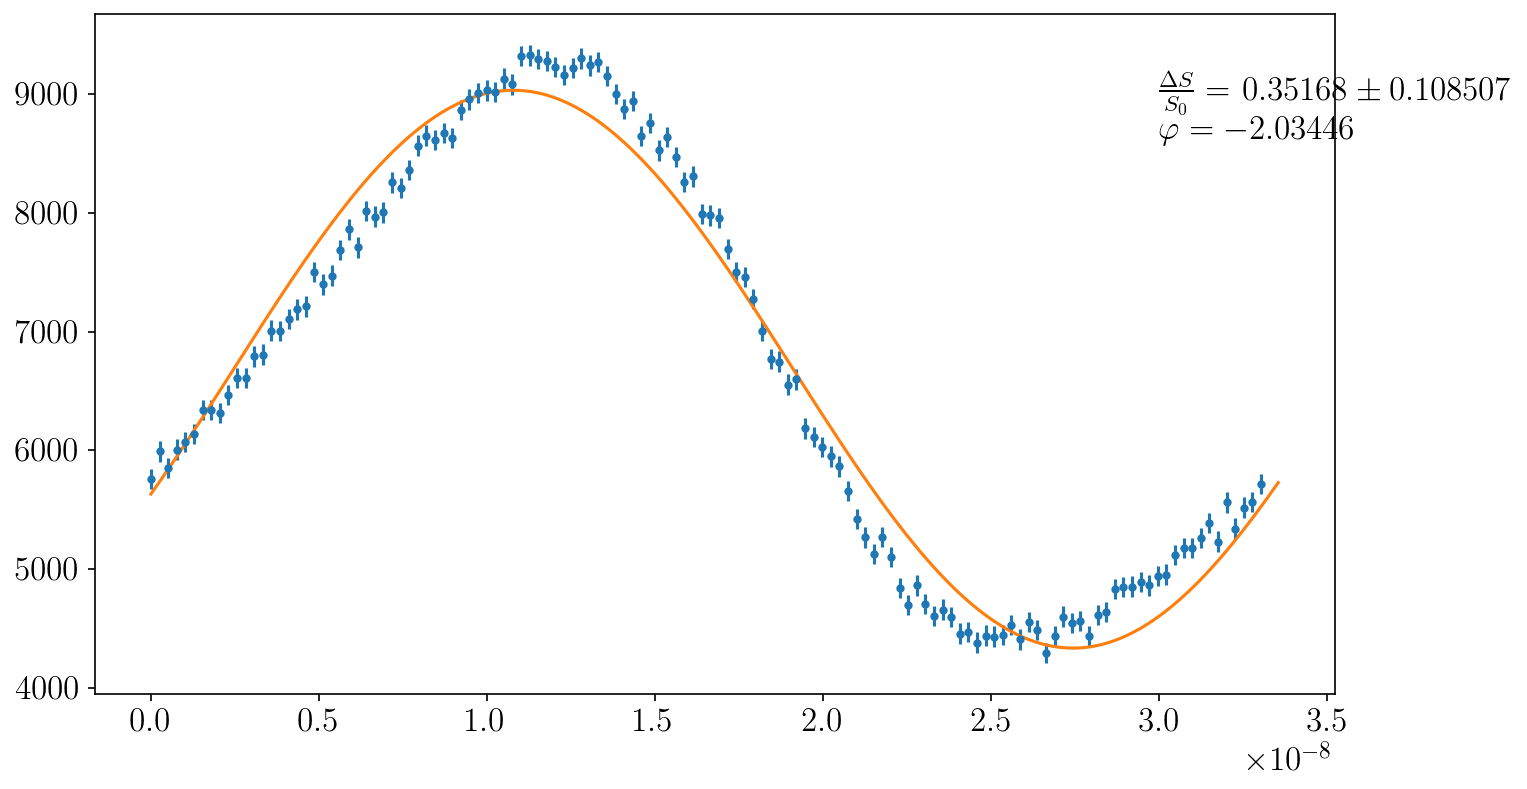

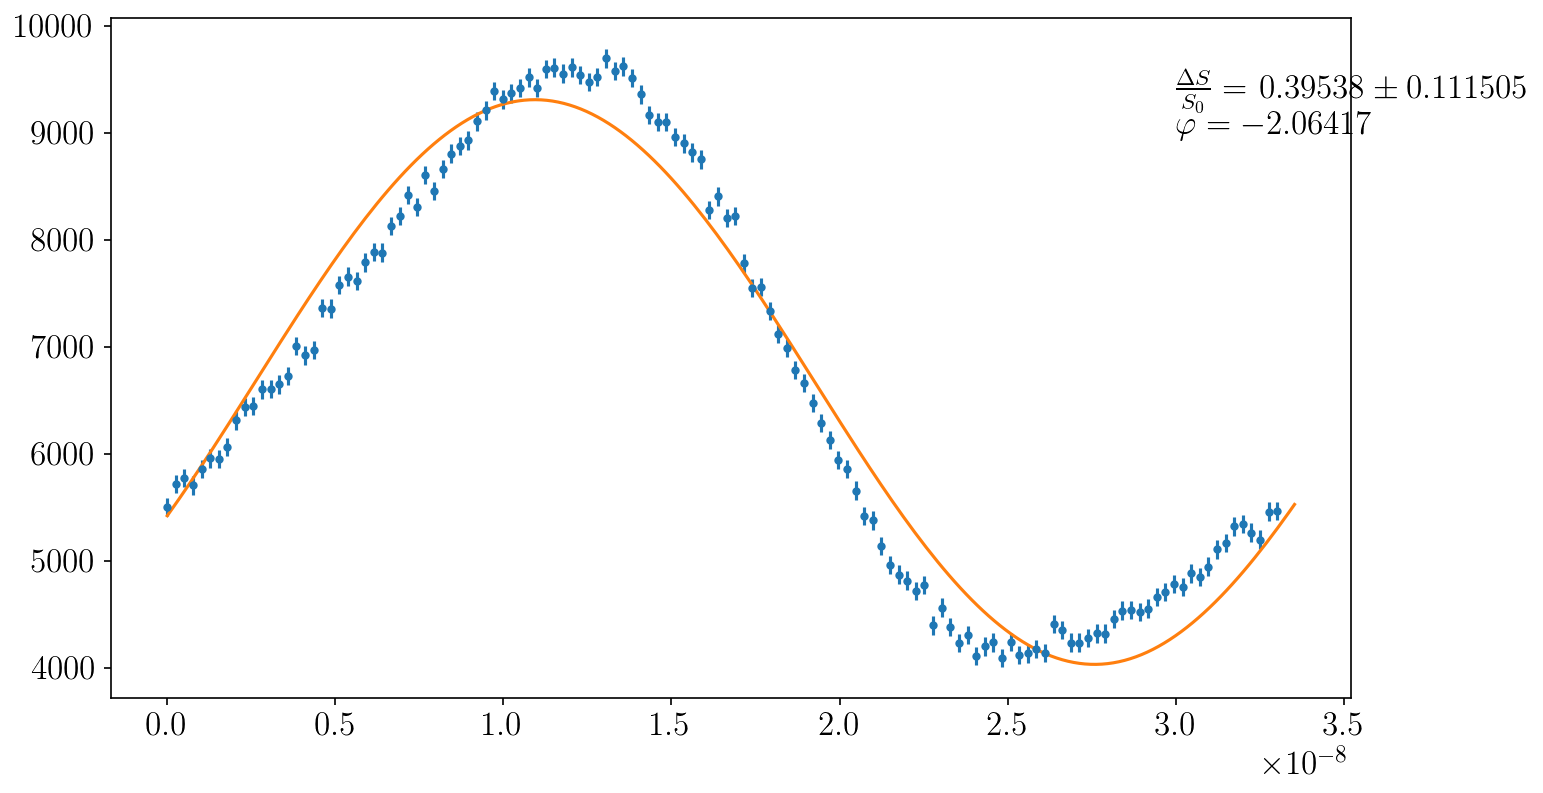

In [19]:
# plot fitu vcetne errorbaru
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func(x[:,i], Omega, time_fit)
    
    plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
    plt.errorbar(t_scale[:fotkor_shape[0]-2],fotkor_bezcond[:fotkor_shape[0]-2,i],yerr=1/np.sqrt(W_vec),fmt='.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} \pm {:.6f}$'.format(x[1,i]/x[0,i], Delta_S_S_ratio_sigma[i])
    plt.text(3e-8, fotkor_bezcond[:,i].max()-500,text) 
    text2 = r'$\varphi  = {:.5f}$'.format(fot_phi[i])
    plt.text(3e-8, fotkor_bezcond[:,i].max()-700,text2) 


Vykresleni vysledne zavislosti.

In [17]:
alpha_bezcond = (voltages_bezcond[:,0] - voltages_bezcond[:,1]) / (voltages_bezcond[:,0] + voltages_bezcond[:,1])
a = 0.000357087248516796
b = 0.0000614272209845667
c = 0.000214572720416111

z_bezcond = a* alpha_bezcond + b* alpha_bezcond**3 + c *alpha_bezcond**5

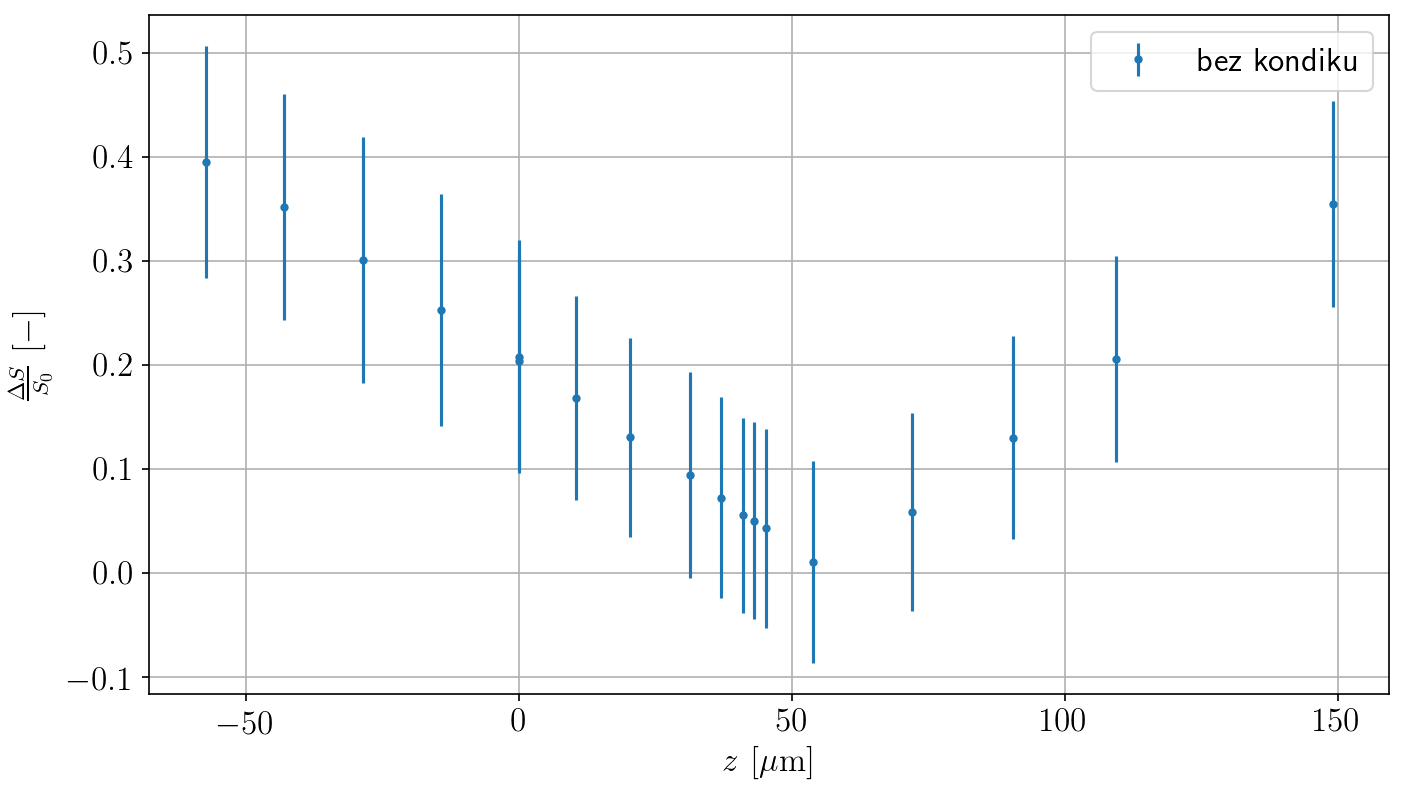

In [18]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(z_bezcond*1e6, np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \frac{\Delta S}{S_0} \, \, \rm [-]$")

plt.legend()
plt.grid()

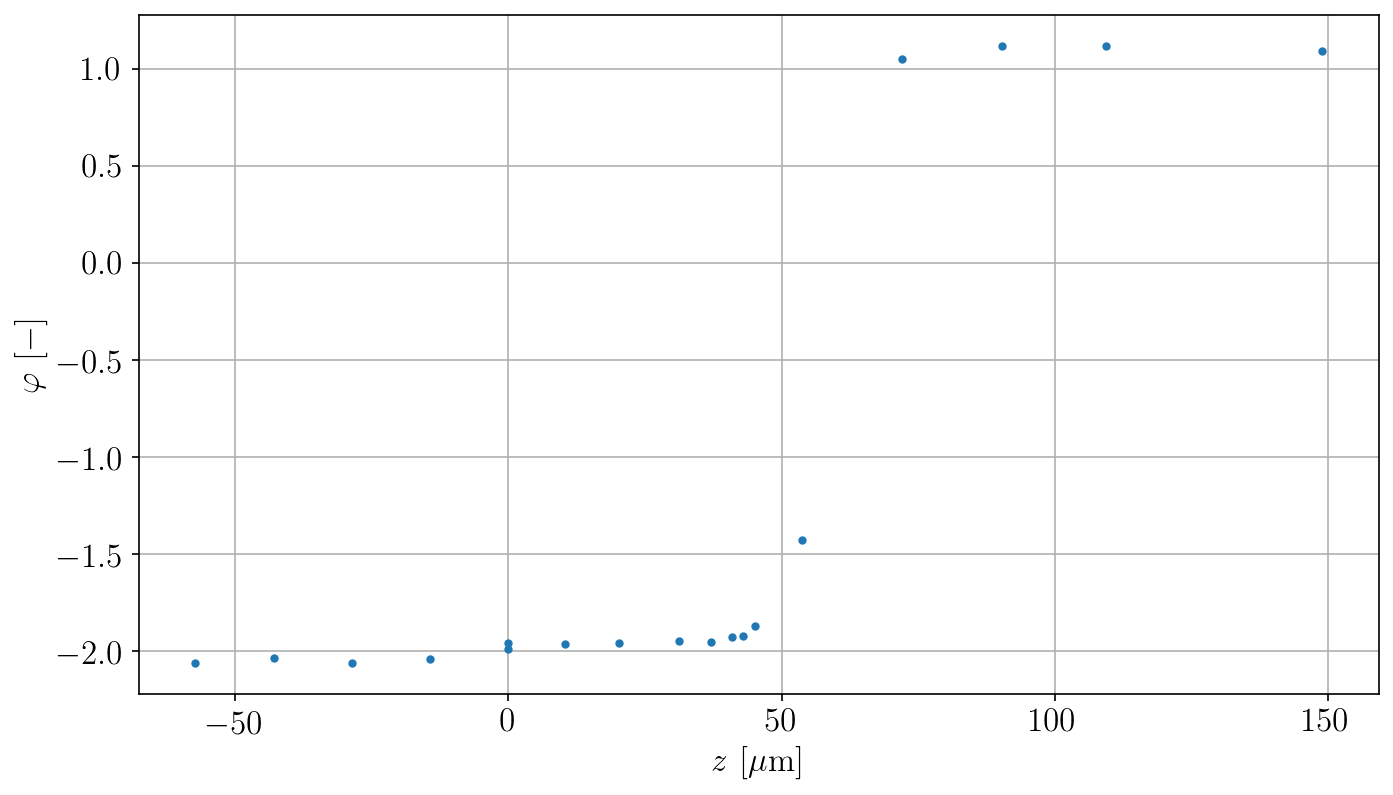

In [27]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
# plt.errorbar(z_bezcond*1e6, fot_phi, yerr=sigmas[2,:], fmt='.', label="bez kondiku")
plt.plot(z_bezcond*1e6, fot_phi, '.')
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \varphi \, \, \rm [-]$")

# plt.legend()
plt.grid()

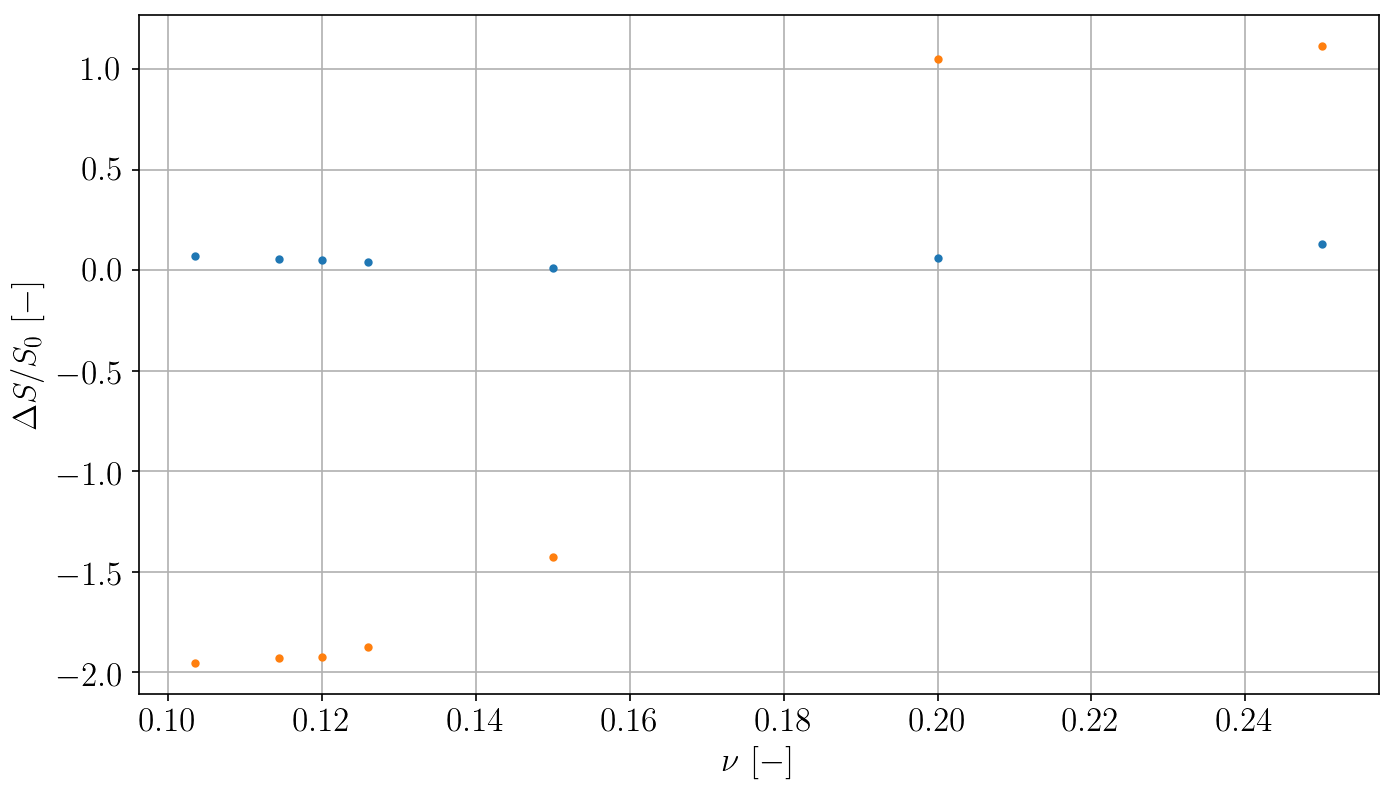

In [30]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

ax = plt.gca()

plt.plot(alpha_bezcond[5:12], np.abs(DeltaS_S_ratio[5:12]), '.')
plt.plot(alpha_bezcond[5:12], fot_phi[5:12], '.')
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ \nu \, \, \rm [-]$")
plt.ylabel(r"$ \Delta S / S_0 \, \, \rm [-]$")

# plt.legend()
plt.grid()

Je nutno poresit errorbary jdouci pod nulu.

## Vypocet el. pole

Nejprve zadam potrebne parametry: detuning cooling laseru, decay rate cooling prechodu, omega, a $\Delta S/S_0$.

In [49]:
#decay_rate = 132e6  # units 2*pi * decay freq

decay_rate = 2*np.pi * 1.75e7  # decay rate dle tabulek NISTu
laser_detun = -30e6 * 2*np.pi  # detuning 
laser_detun_sigma = 5e6 * 2*np.pi # sigma detun

In [50]:
# dalsi parametry
m = 40 * 1.66053904e-27 # calcium mass
k_vec = 2*np.pi * 1/(397e-9) # wave vector
e = 1.60217662e-19 # elem charge

In [51]:
# fce pro fit
from scipy.optimize import fsolve
from scipy.special import j0, j1

def get_A(decay_rate, detun):
    # returns driven oscillator amplitude in point given by detun param.
    return 1 / 2 * (decay_rate / 2 - detun * 1j) / (detun ** 2 + (decay_rate / 2) ** 2)


def fl_signal(beta, laser_detun, Omega, decay_rate):
    # function calculates deltaS/S0 photon-correlation signal
    # input: beta, laser detuning, RF drive freq, decay rate
    A_minus = get_A(decay_rate, laser_detun - Omega)
    A_plus = get_A(decay_rate, laser_detun + Omega)
    A = get_A(decay_rate, laser_detun)

    numer = 2 * j0(beta) * j1(beta) * np.absolute(np.conj(A) * A_plus - A * np.conj(A_minus))
    denom = j0(beta) ** 2 * np.absolute(A) ** 2 + j1(beta) ** 2 * (np.absolute(A_plus) ** 2 + np.absolute(A_minus) ** 2)

    return numer / denom

def get_beta(Omega, decay_rate, laser_detun, norm_mod_amp):
    # function calculates the corresponding beta for given known parameters
    # input: drive frequency, decay_rate, laser detuning, normalized modulation amplitude given by ph_corr_signal
    # output: float value of beta
    def root_func(beta, laser_detun, Omega, decay_rate, norm_mod_amp):
        return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

    sol = fsolve(root_func, np.array([0.2]), args=(laser_detun, Omega, decay_rate, norm_mod_amp), full_output=1)
    return float(sol[0])

## odhad nejistoty pomoci sireni chyb

Vyuzijeme nelinearniho sireni chyb. Tedy
\begin{equation}
    \mathcal{\Sigma}^\beta = \mathcal{J}^\beta \mathcal{\Sigma} \mathcal{J }^{\beta \rm T}
\end{equation}

Kde jakobian $\mathbf{J^\beta}$ ma tvar:
\begin{equation}
	\mathcal{J}^\beta = 
	\begin{pmatrix}
		\frac{\partial \beta}{\partial \left(\frac{\Delta S}{S_0}\right)} & \frac{\partial \beta}{\partial \Omega}      & \frac{\partial \beta}{\partial \Delta}   \\
    \end{pmatrix}
	\quad .
\end{equation}

Kovariancni matice $\mathcal{\Sigma}$ ma tvar:
\begin{equation}
	\mathcal{\Sigma} = 
	\begin{pmatrix}
		\sigma_{\frac{\Delta S}{S_0}}^2 & 0      & 0   \\
        0 & \sigma_{\Omega}^2      & 0   \\
        0 & 0      & \sigma_{\Delta}^2   \\
    \end{pmatrix}
	\quad .
\end{equation}

Jakobian $\mathcal{J}^\beta$ vyjadrime pomoci jakobianu $\mathcal{J}^g$, kde $g(\frac{\Delta S}{S_0}, \Omega, \Gamma, \Delta, \beta)=0$, coz je rovnice, kterou resime numericky.

In [52]:
from scipy.optimize import approx_fprime

def root_func(x):
    [norm_mod_amp, Omega, decay_rate, laser_detun, beta] = x
    return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

# get beta
#from photon_correlation_functions import get_beta

beta = np.zeros(fotkor_shape[1])
beta_sigma = np.zeros(fotkor_shape[1])
for k in range(fotkor_shape[1]):
    beta[k] = get_beta(Omega, decay_rate, laser_detun, DeltaS_S_ratio[k])

    # aproximation of jacobian fce g

    jacob_g = approx_fprime([DeltaS_S_ratio[k], Omega, decay_rate, laser_detun, beta[k]], root_func, 
                  np.array([beta[k], laser_detun, Omega, decay_rate, DeltaS_S_ratio[k]])*8e-7)

    jacob_beta = 1/jacob_g[4] * jacob_g[:4]  

    # definice kovar. matice sigma:

    sigma_matrix = np.diag([Delta_S_S_ratio_sigma[k]**2, Omega_sigma**2, 0, laser_detun_sigma**2])
    covar_beta = jacob_beta @ sigma_matrix @ np.transpose(jacob_beta)
    beta_sigma[k] = np.sqrt(covar_beta)

In [53]:
# get E-fields with unc as well
# get E-fields
E_rf = (m*Omega**2 / (k_vec*e)) * beta
E_rf_sigma = np.sqrt( (beta_sigma*m*Omega**2 / (k_vec*e))**2 + (2*m*Omega / (k_vec*e) * beta * Omega_sigma)**2  ) # propagase chyb

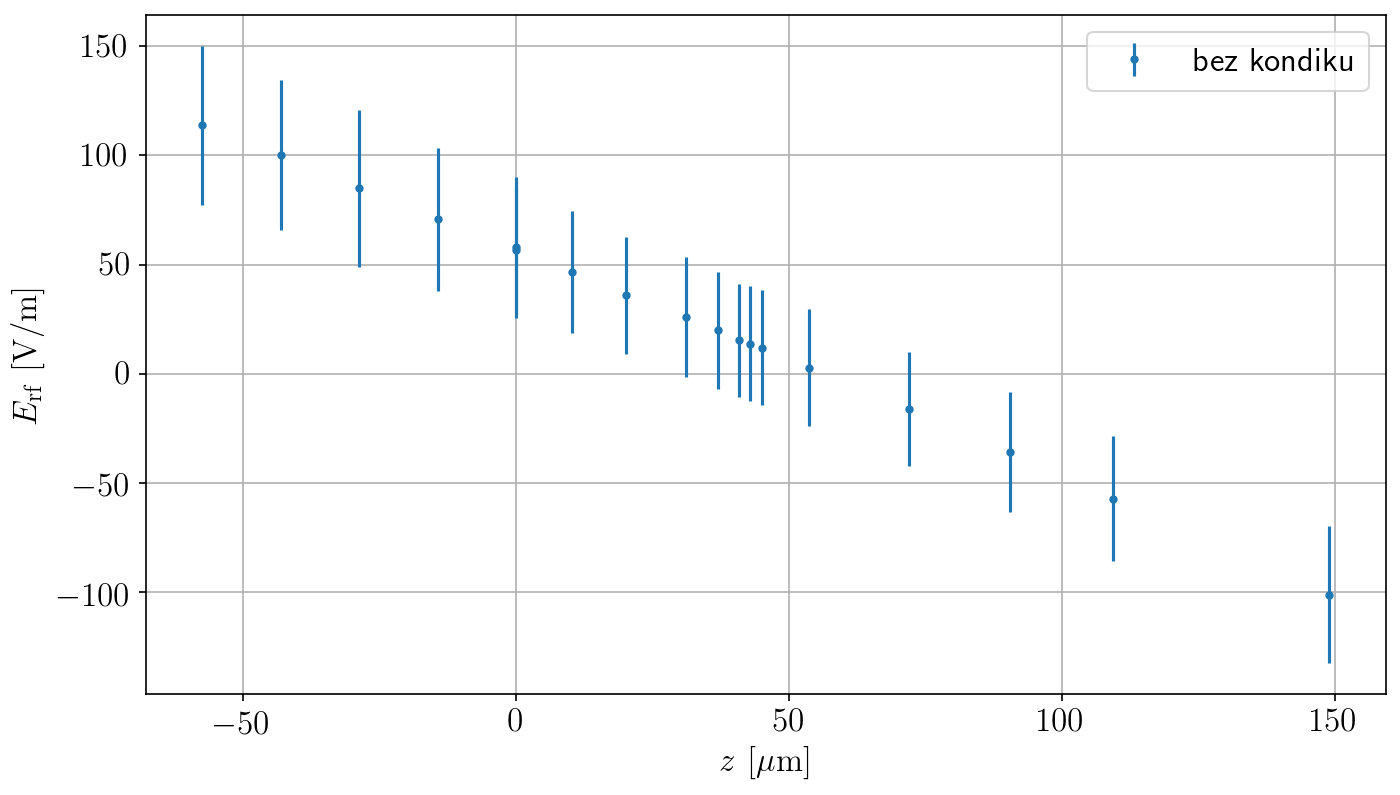

In [54]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(z_bezcond*1e6, E_rf, yerr=E_rf_sigma, fmt='.', label="bez kondiku")
#plt.plot(z_bezcond*1e6, E_rf,'.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ E_{\rm rf} \, \, \rm [V/m]$")

plt.legend()
plt.grid()

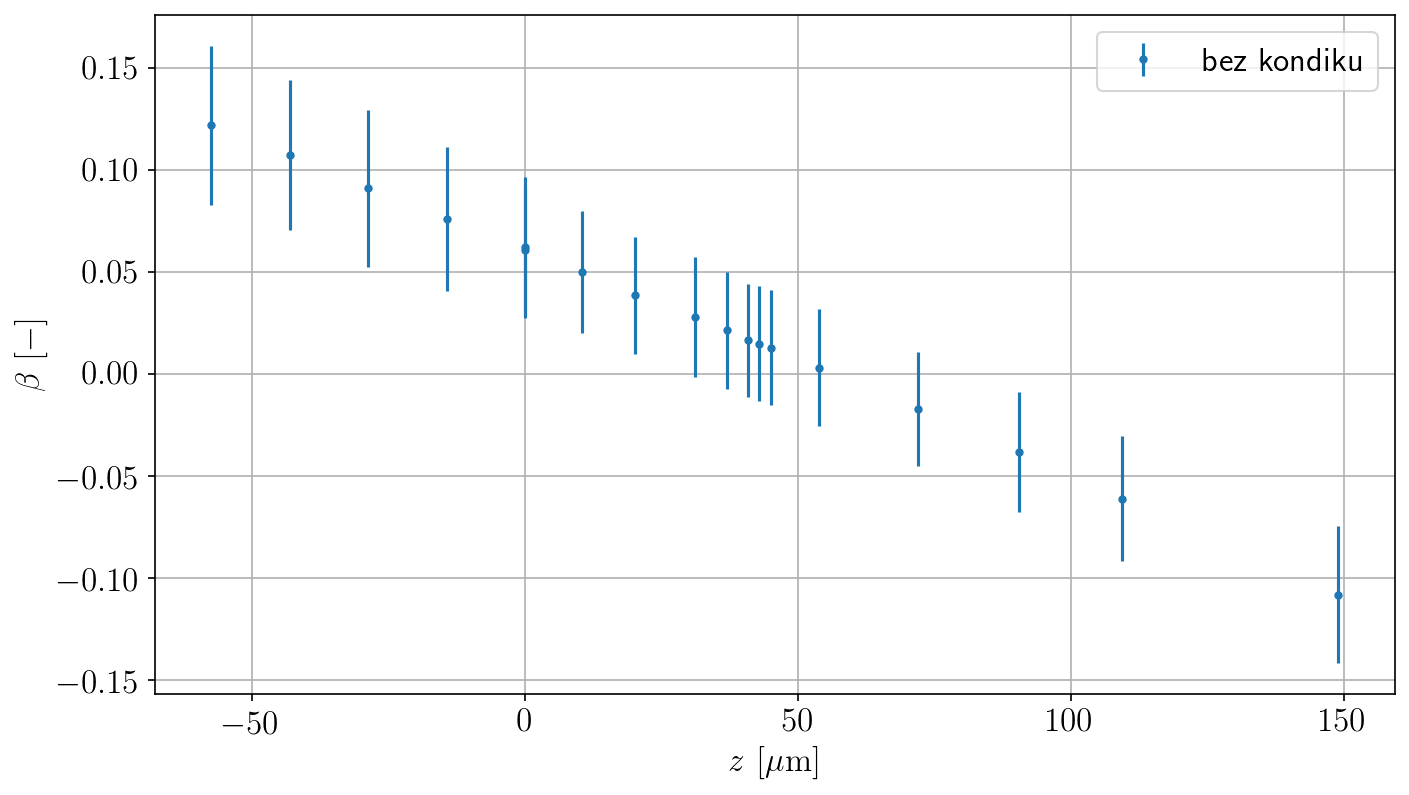

In [55]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(z_bezcond*1e6, beta, yerr=beta_sigma, fmt='.', label="bez kondiku")
#plt.plot(z_bezcond*1e6, E_rf,'.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \beta \, \, \rm [-]$")

plt.legend()
plt.grid()

## Odhad minima MM

In [56]:
# minimum beta: 
ind_min = np.argmin(np.abs(beta))
beta_min = beta[ind_min]
beta_min_sigma = beta_sigma[ind_min]

z_beta_min = z_bezcond[ind_min]

Prolozenim zavislosti $\beta(z)$ ziskame odhad idealniho nastaveni napeti na DC elektrodach pasti.

In [57]:
# fce vracejici residua

def MM_resid(x, beta, z_points, weights):
    return( np.sqrt(weights)*(beta - x[0] - x[1]*z_points) )

def MM_line(x, z):
    return(x[0] + x[1]*z)

In [58]:
# fit zavislosti \beta(z)

x0 = [0.06, -0.1]
weights_beta = 1/beta_sigma**2

fit = least_squares(MM_resid,x0, args=(beta, z_bezcond, weights_beta) , ftol=1e-10, xtol=1e-10)
linfit_bezcond = fit.x

linfit_bezcond_sigma_matrix  = np.linalg.inv( 
                                    np.transpose(fit.jac) @ np.diag(weights_beta) @ fit.jac ) # kovariancni matice linearniho fitu


fit

 active_mask: array([0., 0.])
        cost: 0.02252307836261098
         fun: array([ 0.02153582, -0.01870118,  0.00688397, -0.00824679,  0.0406558 ,
        0.04095454,  0.0201319 ,  0.04382476,  0.05133472,  0.05080986,
        0.04514167,  0.01756903, -0.04763422, -0.13135893, -0.03589929,
       -0.05181286, -0.04085872, -0.07570251])
        grad: array([-5.55475665e-11, -1.61811133e-12])
         jac: array([[-2.88404955e+01, -0.00000000e+00],
       [-3.15357826e+01, -0.00000000e+00],
       [-3.35034954e+01, -3.48507437e-04],
       [-3.48843189e+01, -7.05491770e-04],
       [-3.40214782e+01, -1.06296271e-03],
       [-3.47564359e+01, -1.28635675e-03],
       [-3.60745878e+01, -1.47750599e-03],
       [-3.56759946e+01, -1.53271049e-03],
       [-3.54610924e+01, -1.60009972e-03],
       [-3.48239943e+01, -1.87306768e-03],
       [-3.56520493e+01, -2.56614649e-03],
       [-3.40421484e+01, -3.07881126e-03],
       [-3.26146303e+01, -3.56497876e-03],
       [-2.96057545e+01, -4.41

In [59]:
np.sqrt( linfit_bezcond_sigma_matrix )

/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([[3.06296615e-04,            nan],
       [           nan, 5.23844824e+00]])

In [60]:
# ocekavany nulovy MM
z_fit = np.linspace(z_bezcond.min(), z_bezcond.max(), 200)
beta_fit = MM_line(linfit_bezcond, z_fit)

z_MM_zero = - linfit_bezcond[0]/linfit_bezcond[1]  # expected MM zero

# -- zakon sireni chyb fitu na parametr z_MM_zero
jacob_MM_zero = np.array([-1/linfit_bezcond[1], linfit_bezcond[0]/linfit_bezcond[1]**2 ])
z_MM_zero_sigma = jacob_MM_zero @ linfit_bezcond_sigma_matrix @ np.transpose(jacob_MM_zero)

print("z_EMM_zero = ", z_MM_zero*1e6)
print("z_EMM_zero_sigma = ", z_MM_zero_sigma*1e6)

z_EMM_zero =  55.237852719297926
z_EMM_zero_sigma =  4.443817541725046e-08


vidime, ze nejistota urceni teto polohy je zanedbatelna => dale se ji nebudu zabyvat.

Definuju fci $ z(\alpha)$, pomoci ni pak definuju inverzni fci $ \alpha(z)$, urcim tedy, pro ktere $\alpha$ predpokladame nulovy MM.

In [61]:
def get_alpha(z):
    # input: z - desired position of ion w. r. t. the position where the ion is when voltages are set to equal values on 
                                        # both axial electrodes  units [m]
    # output: value of alpha
    
    from scipy.optimize import fsolve
    
    def z_ion_conf(alpha):

        a = 0.000357087248516796
        b = 0.0000614272209845667
        c = 0.000214572720416111

        return( (a* alpha + b* alpha**3 + c *alpha**5) )
    
    def func_solve(x,z):
        return( z - z_ion_conf(x) )
    
    x0 =[0.1]
    return fsolve(func_solve, x0, args=(z))

In [62]:
alpha_MM_zero = get_alpha(z_MM_zero)   # alpha pro ktere ocekavame nulovy axialni MM

# vypocet potrebnych napeti na ax. elektrody
U_stred = 500  # stredni napeti na elektrodaach
U_dc_5 = U_stred*(1+alpha_MM_zero)
U_dc_6 = U_stred*(1-alpha_MM_zero)

print("U5 = ", U_dc_5)
print("U6 = ", U_dc_6)

U5 =  [577.00480907]
U6 =  [422.99519093]


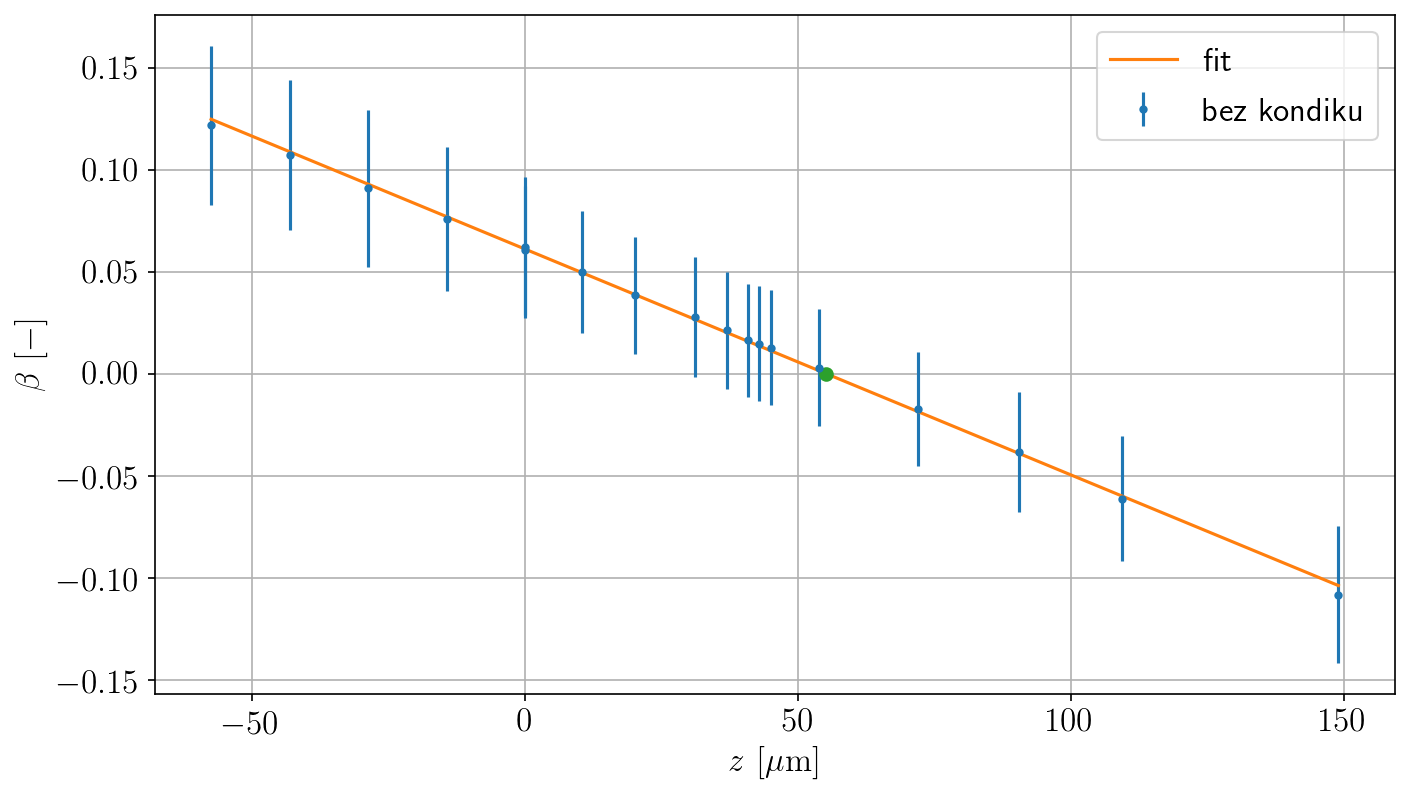

In [63]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(z_bezcond*1e6, beta, yerr=beta_sigma, fmt='.', label="bez kondiku")
plt.plot(z_fit*1e6, beta_fit, label="fit")
plt.plot(z_MM_zero*1e6, [0], "o")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \beta \, \, \rm [-]$")

plt.legend()
plt.grid()

## vykresleni zavislosti na $\alpha$ nebo-li v diplomkce $\nu$

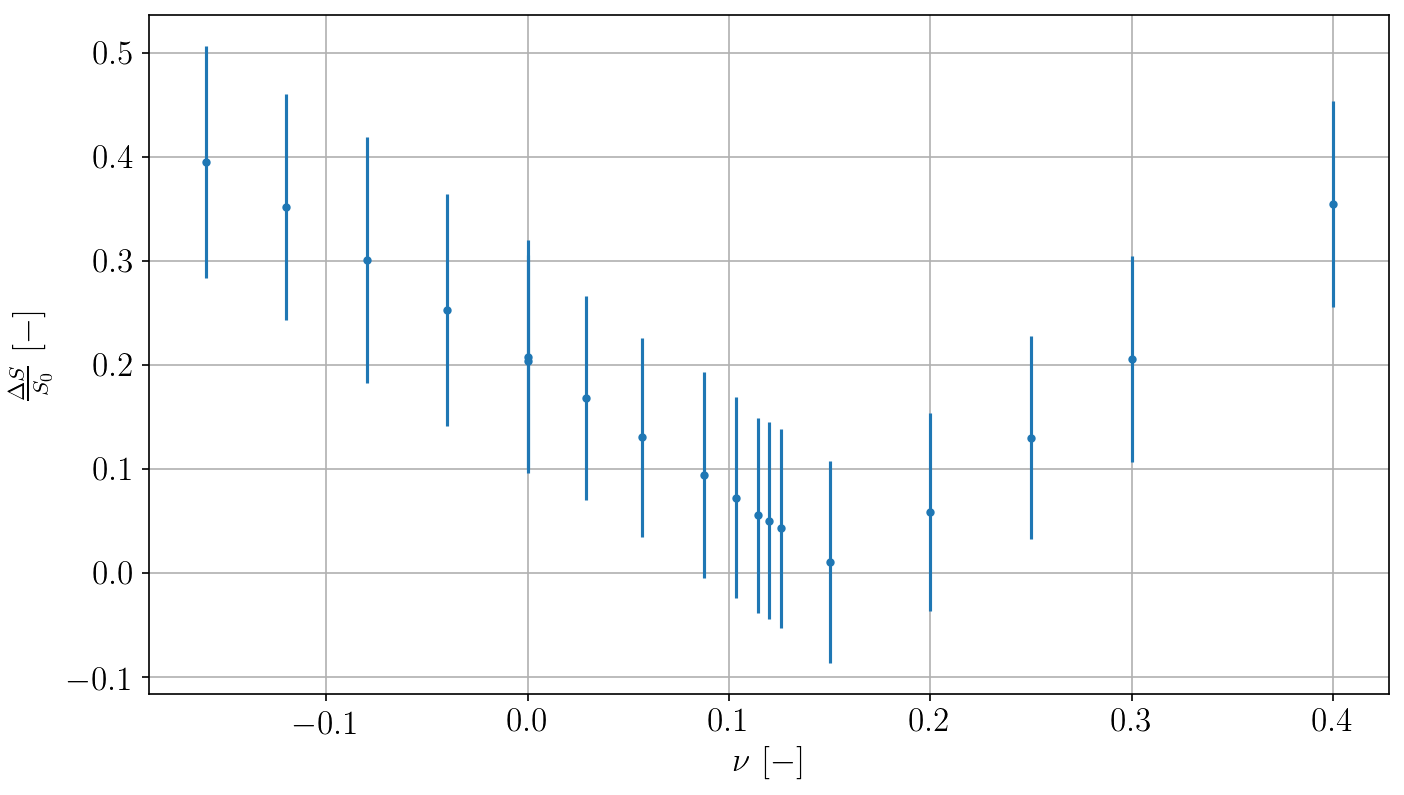

In [71]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(alpha_bezcond, np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ \nu \, \, \rm [-]$")
plt.ylabel(r"$ \frac{\Delta S}{S_0} \, \, \rm [-]$")

# plt.legend()
plt.grid()

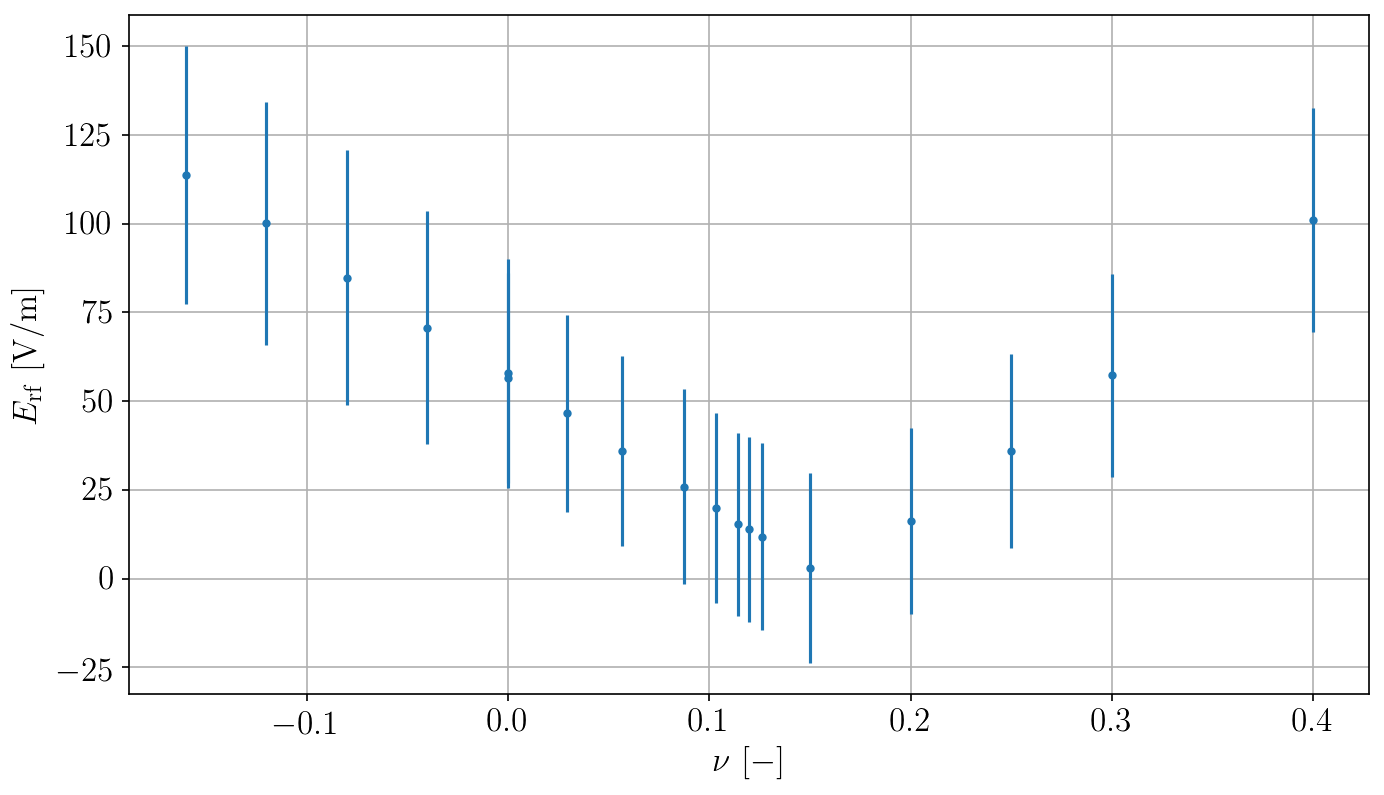

In [72]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(alpha_bezcond, np.abs(E_rf), yerr=E_rf_sigma, fmt='.', label="bez kondiku")
#plt.plot(z_bezcond*1e6, E_rf,'.', label="bez kondiku")
plt.xlabel(r"$ \nu \, \, \rm [-]$")
plt.ylabel(r"$ E_{\rm rf} \, \, \rm [V/m]$")

# plt.legend()
plt.grid()

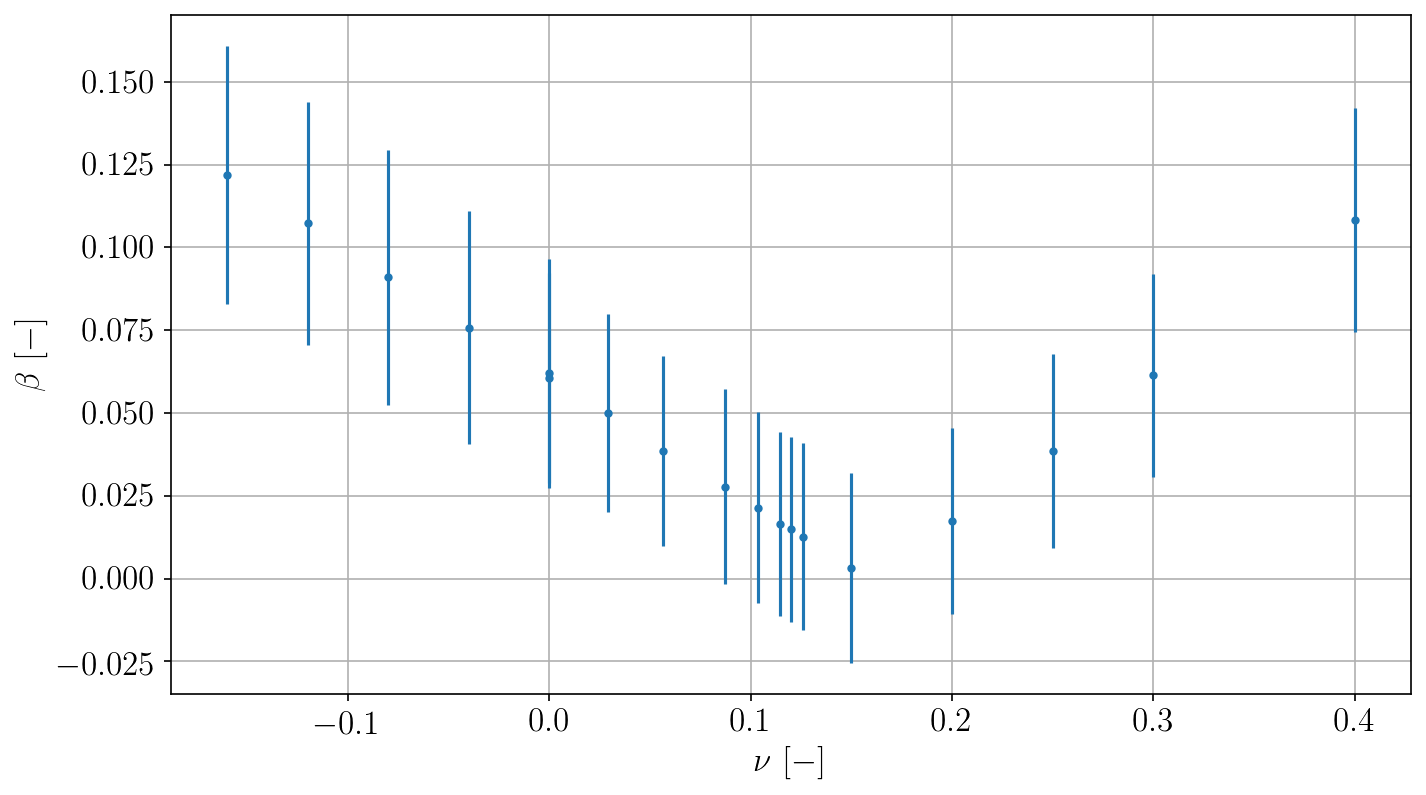

In [73]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(alpha_bezcond, np.abs(beta), yerr=beta_sigma, fmt='.', label="bez kondiku")
#plt.plot(z_bezcond*1e6, E_rf,'.', label="bez kondiku")
plt.xlabel(r"$ \nu \, \, \rm [-]$")
plt.ylabel(r"$ \beta \, \, \rm [-]$")

# plt.legend()
plt.grid()

In [96]:
print(DeltaS_S_ratio[9])
print(Delta_S_S_ratio_sigma[9])
print(fot_phi[9])
print(sigmas[2,9])

-0.010412359234912974
0.09746333148292263
-1.427506538753384
13.239557741396794
